# SB5 — Sensitivity to noise

In [1]:
# SB6: Show-only wie in SB5 (keine Dateien speichern)
# ------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure as mfigure
from IPython.display import display
import importlib

# Importe, damit evtl. rcParams aus evaluator.py sichtbar sind
import evaluator, main  # keine Änderungen an diesen Modulen

# 1) "tight" & constrained_layout abschalten (wie SB5-Feeling)
mpl.rcParams["savefig.bbox"] = "standard"
mpl.rcParams["figure.constrained_layout.use"] = False

# 2) Speichern abfangen: savefig zeigt die Figur nur an (kein Write)
try:
    _ORIG_PLT_SAVEFIG
except NameError:
    _ORIG_PLT_SAVEFIG = plt.savefig

def _plt_savefig_show(*args, **kwargs):
    # Statt speichern einfach die aktuelle Figur anzeigen
    fig = plt.gcf()
    display(fig)  # zeigt inline
    # nichts speichern

plt.savefig = _plt_savefig_show

try:
    _ORIG_FIG_SAVEFIG
except NameError:
    _ORIG_FIG_SAVEFIG = mfigure.Figure.savefig

def _fig_savefig_show(self, *args, **kwargs):
    # Falls fig.savefig(...) verwendet wird: ebenfalls nur anzeigen
    display(self)  # zeigt die konkrete Figure
    # nichts speichern

mfigure.Figure.savefig = _fig_savefig_show

# 3) Optional: Main nicht zum Batch-Export nutzen (Plots kommen eh inline)
#    (Falls du run_and_collect -> main.main() nutzt, ist das egal, da savefig gepatcht ist.)
# main.PLOT_IN_MAIN = True  # Default ist True; kann so bleiben
# ------------------------------------------------------------------

print("SB6 ist jetzt im Show-only-Modus (keine PNGs, nur Inline-Anzeige).")


SB6 ist jetzt im Show-only-Modus (keine PNGs, nur Inline-Anzeige).


In [2]:

import os, sys, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown, HTML

# import matplotlib as mpl
# mpl.rcParams["savefig.bbox"] = "standard"
# mpl.rcParams["figure.autolayout"] = False
# mpl.rcParams["figure.constrained_layout.use"] = False


# Ensure local modules are importable
ROOT = Path("/mnt/data").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import main  # uses /mnt/data/main.py
from evaluator import (
    load_logs, aggregate_regret, plot_regret_curves, add_normalized_regret,
    aggregate_regret_norm, plot_regret_norm_curves, plot_box_regret_at_T,
    plot_box_regret_norm_at_T, plot_box_best_value_at_T, plot_ybest_curves,
    rank_by_group, winrate_by_group, plot_rank_heatmap, plot_winrate_heatmap,
    save_rank_tables, save_tables, export_best_at_T_table,
    save_best_at_T_tables_as_png, render_boxplot_side_tables, export_auc_table_from_agg
)  # uses /mnt/data/evaluator.py

def find_latest_results(exp_name: str) -> Path:
    root = Path("results")
    if not root.exists():
        raise FileNotFoundError("No results/ folder yet.")
    cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
    if not cands:
        # fallback: any folder containing exp_name
        cands = [p for p in root.glob("*_*") if exp_name in p.name]
    if not cands:
        raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
    return max(cands, key=lambda p: p.stat().st_mtime)

def show_pngs(paths, width=820):
    for p in paths:
        p = Path(p)
        if p.exists():
            display(Image(filename=str(p), width=width))

def show_all_core_plots(outdir: Path):
    # Display the plots main.py already created when PLOT_IN_MAIN=True
    plots = outdir / "plots"
    # groups = [
    #     "regret_curves", "regret_curves_obs", "regret_norm_curves",
    #     "regret", "regret_obs", "regret_norm", "best_value", "heatmaps"
    # ]
    # groups = [
    #     "regret_curves", "regret_norm_curves",
    #     "regret", "regret_norm", "best_value", "heatmaps"
    # ]
    groups = [
        "regret_curves",
        "regret"
    ]
    all_imgs = []
    for g in groups:
        d = plots / g
        if d.exists():
            all_imgs += sorted(d.glob("*.png"))
    if all_imgs:
        print(f"Showing {len(all_imgs)} plot images ...")
        show_pngs(all_imgs)

    # # Also show the small per-boxplot side tables (PNG) if present
    # table_pngs = sorted((outdir/"plots").rglob("*_table.png"))
    # if table_pngs:
    #     print(f"Showing {len(table_pngs)} boxplot side-table PNGs ...")
    #     show_pngs(table_pngs, width=640)

    # # And global 'best_at_T' PNG tables
    # global_tables = sorted((outdir/"tables").glob("best_at_T_*.png"))
    # if global_tables:
    #     print("Global Best@T tables:")
    #     show_pngs(global_tables, width=720)

def show_core_dataframes(outdir: Path):
    # Load unified logs
    df = load_logs(outdir)
    print("all_runs.csv shape:", df.shape)
    # Final rows per run for boxplots
    keys = ["problem","method","seed","budget"]
    if "noise_pct" in df.columns:
        keys.append("noise_pct")
    dff = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    display(Markdown("**Final rows per run (for boxplots):**"))
    display(dff.head(20))

    # Aggregates for curves (true & observed regret)
    agg_true = aggregate_regret(df, use_observed=False)
    display(Markdown("**Aggregate (true regret) for curves:**"))
    display(agg_true.head(20))
    # agg_obs = aggregate_regret(df, use_observed=True)
    # display(Markdown("**Aggregate (observed regret) for curves:**"))
    # display(agg_obs.head(20))

    # Normalized regret
    dfn = add_normalized_regret(df.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        display(Markdown("**Aggregate (normalized regret) for curves:**"))
        display(aggn.head(20))

# ---- safe PNG render to avoid gigantic bbox issues in notebooks ----
import io, matplotlib.pyplot as plt
from IPython.display import Image as _IPyImage, display as _ipy_display

def _safe_show(fig, dpi=150):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches="standard")  # << wichtig: standard!
    buf.seek(0)
    _ipy_display(_IPyImage(data=buf.read()))
    plt.close(fig)

def run_and_collect(exp_name: str):
    # main.main() uses current module-level config values set above.
    print("Launching main.main() ...")
    main.main()
    outdir = find_latest_results(exp_name)

    # Recompute aggregates and export AUC tables
    from evaluator import aggregate_regret, aggregate_regret_norm, add_normalized_regret, export_auc_table_from_agg
    df_all = load_logs(outdir)

    agg_true = aggregate_regret(df_all, use_observed=False)
    export_auc_table_from_agg(agg_true, outdir, label="true")

    # agg_obs = aggregate_regret(df_all, use_observed=True)
    # export_auc_table_from_agg(agg_obs, outdir, label="obs")

    dfn = add_normalized_regret(df_all.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        export_auc_table_from_agg(aggn, outdir, label="norm")

    print("Artifacts written to:", outdir)
    # Ensure all table PNGs exist (best@T + per-boxplot)
    try:
        save_best_at_T_tables_as_png(outdir, decimals=3)
    except Exception as e:
        print("[warn] save_best_at_T_tables_as_png:", e)
    try:
        render_boxplot_side_tables(outdir, decimals=3)
    except Exception as e:
        print("[warn] render_boxplot_side_tables:", e)
    return outdir

# --- HOTFIX 1: Entschärfe savefig, wenn bbox_inches="tight" kommt (ohne deinen Code zu ändern)
import matplotlib.pyplot as plt
from functools import wraps

_ORIG_SAVEFIG = plt.savefig

@wraps(_ORIG_SAVEFIG)
def _savefig_no_tight(*args, **kwargs):
    # Verhindert riesige Bounding Boxes durch "tight"
    if kwargs.get("bbox_inches") == "tight":
        kwargs["bbox_inches"] = None
    # Optional: DPI deckeln (beugt sehr großen PNGs vor)
    if "dpi" in kwargs and kwargs["dpi"] and kwargs["dpi"] > 120:
        kwargs["dpi"] = 120
    return _ORIG_SAVEFIG(*args, **kwargs)

plt.savefig = _savefig_no_tight
print("✓ Hotfix aktiv: savefig tight→standard, dpi≤120")



✓ Hotfix aktiv: savefig tight→standard, dpi≤120


In [3]:
# --- CONFIG --------------------------------------------------------------
main.EXP_NAME      = 'SB7_Problem_class'
main.PROBLEMS      = ['Sphere', 'Branin', 'Rosenbrock', 'Rastrigin', 'Hartmann6']
main.METHODS       = ['DOE_LHS', 'BO_EI', 'Random']

main.BUDGETS       = [50]
main.SEEDS         = list(range(40))
main.NOISE_PCTS    = [0.2]
main.INIT_FACTOR   = 2.0
main.PLOT_IN_MAIN  = True
main.GENERATE_SAMPLES   = False
main.FINAL_SAMPLES_AT_T = True
main.K_EVERY            = 4
print("✓ CONFIG applied here (overrides main.py defaults during this run).")


✓ CONFIG applied here (overrides main.py defaults during this run).


In [4]:
# === SB6 Rendering Guard & Helpers (py38-safe, ONE DROP-IN) ===
import io, math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure as mfigure
from functools import wraps
from typing import Optional, Union
from IPython.display import Image as _IPyImage, display as _ipy_display

# Inline-Backend sicher aktivieren
try:
    plt.switch_backend("module://matplotlib_inline.backend_inline")
except Exception:
    try:
        from IPython import get_ipython
        get_ipython().run_line_magic("matplotlib", "inline")
    except Exception:
        pass

# SB6-Style RC-Params (kein tight/constrained/auto layout)
mpl.rcParams["savefig.bbox"] = "standard"
mpl.rcParams["figure.autolayout"] = False
mpl.rcParams["figure.constrained_layout.use"] = False

_MAX_PX = 65000   # unter 2^16 bleiben
_MAX_DPI = 120
_MIN_DPI = 72

def _cap_dpi_for_fig(fig: mfigure.Figure, dpi: Optional[Union[int, float]]) -> int:
    """Wähle DPI so, dass max(Pixelbreite/-höhe) < _MAX_PX bleibt."""
    use_dpi = int(dpi if (isinstance(dpi, (int, float)) and dpi > 0) else (getattr(fig, "dpi", 100) or 100))
    w_in, h_in = fig.get_size_inches()
    try:
        px_w = int(w_in * use_dpi); px_h = int(h_in * use_dpi)
    except Exception:
        return min(_MAX_DPI, max(_MIN_DPI, use_dpi))
    px_max = max(px_w, px_h)
    if px_max > _MAX_PX and px_max > 0:
        scale = float(_MAX_PX) / float(px_max)
        use_dpi = max(_MIN_DPI, int(math.floor(use_dpi * scale)))
    return int(min(use_dpi, _MAX_DPI))

# --- plt.savefig patch: tight neutralisieren, DPI deckeln ---
_ORIG_PLT_SAVEFIG = plt.savefig
@wraps(_ORIG_PLT_SAVEFIG)
def _plt_savefig_no_tight(*args, **kwargs):
    if kwargs.get("bbox_inches") == "tight":
        kwargs["bbox_inches"] = None
    if "dpi" in kwargs:
        try:
            if kwargs["dpi"] > _MAX_DPI:
                kwargs["dpi"] = _MAX_DPI
        except Exception:
            kwargs["dpi"] = _MAX_DPI
    return _ORIG_PLT_SAVEFIG(*args, **kwargs)
plt.savefig = _plt_savefig_no_tight

# --- Figure.savefig patch: tight neutralisieren, DPI dynamisch kappen ---
_ORIG_FIG_SAVEFIG = mfigure.Figure.savefig
@wraps(_ORIG_FIG_SAVEFIG)
def _fig_savefig_no_tight(self, *args, **kwargs):
    if kwargs.get("bbox_inches") == "tight":
        kwargs["bbox_inches"] = None
    kwargs["dpi"] = _cap_dpi_for_fig(self, kwargs.get("dpi", None))
    return _ORIG_FIG_SAVEFIG(self, *args, **kwargs)
mfigure.Figure.savefig = _fig_savefig_no_tight

# Sicheres Inline-Rendern (statt print(fig))
def sb6_show(fig, dpi: int = 110):
    dpi = int(min(_MAX_DPI, max(_MIN_DPI, dpi)))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches=None)
    buf.seek(0)
    _ipy_display(_IPyImage(data=buf.read()))
    plt.close(fig)

def sb6_show_current(dpi: int = 110):
    sb6_show(plt.gcf(), dpi=dpi)

# Schwere Läufe ohne Inline-Rendern ausführen, danach sauber zurück
def sb6_run(fn, *args, **kwargs):
    prev_backend = plt.get_backend()
    try:
        plt.switch_backend("Agg")
        res = fn(*args, **kwargs)
    finally:
        try:
            plt.switch_backend("module://matplotlib_inline.backend_inline")
        except Exception:
            try:
                from IPython import get_ipython
                get_ipython().run_line_magic("matplotlib", "inline")
            except Exception:
                plt.switch_backend(prev_backend)
        plt.close("all")
    return res

print("✓ SB6 guard loaded (py38/py39-safe). Use sb6_run(...) and sb6_show(fig).")


✓ SB6 guard loaded (py38/py39-safe). Use sb6_run(...) and sb6_show(fig).


Launching main.main() ...
[run] Sphere | DOE_LHS | seed=0 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=1 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=2 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=3 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=4 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=5 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=6 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=7 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=8 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=9 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=10 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=11 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=12 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=13 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=14 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=15 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=16 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=17 | T=50 | noise=0.20
[run] Sphere | DOE_LHS | seed=

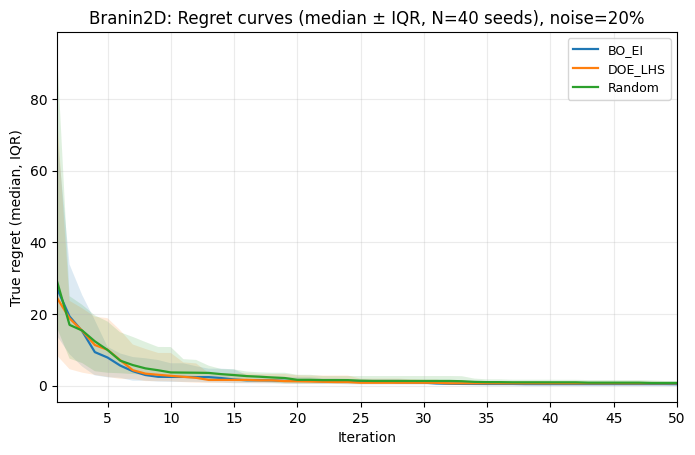

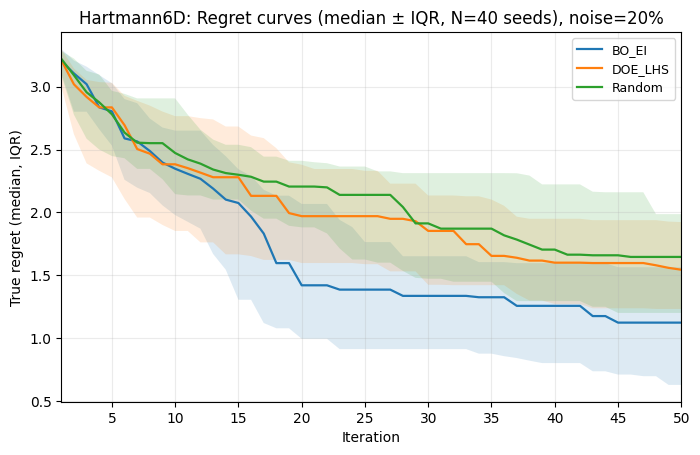

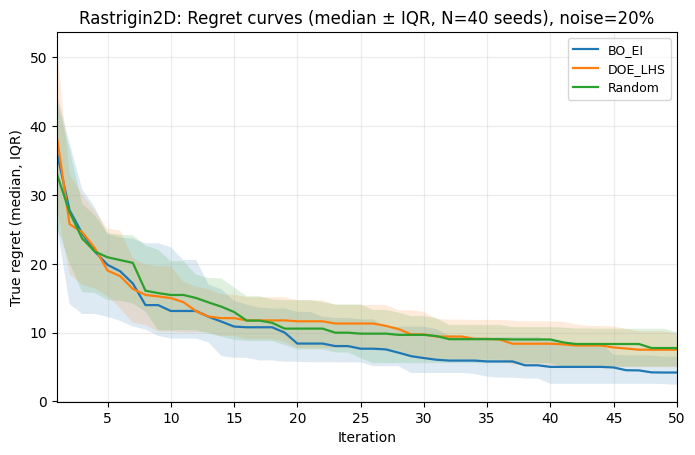

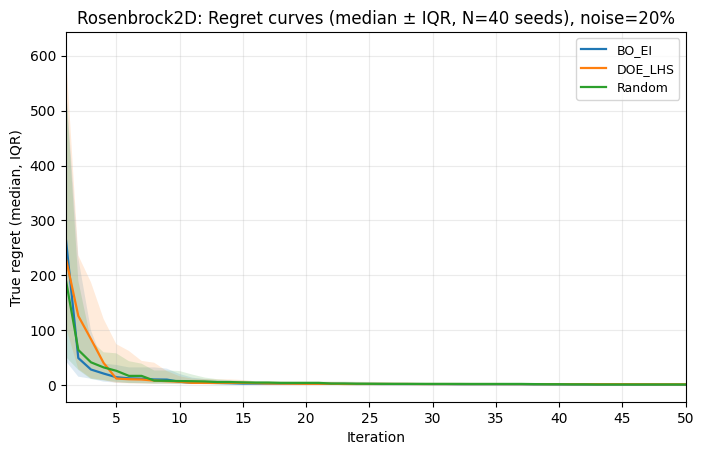

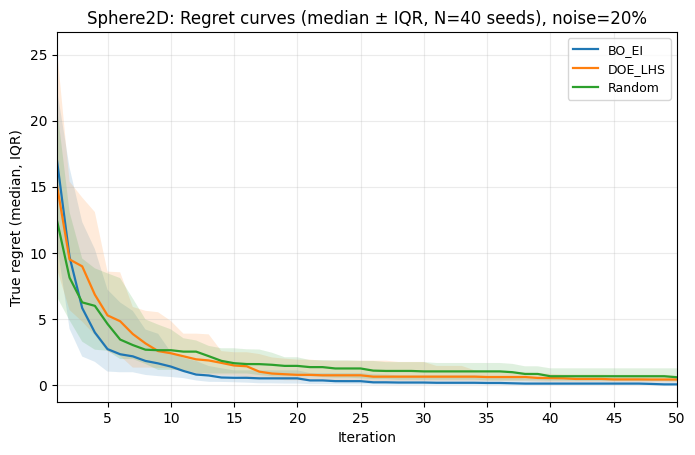

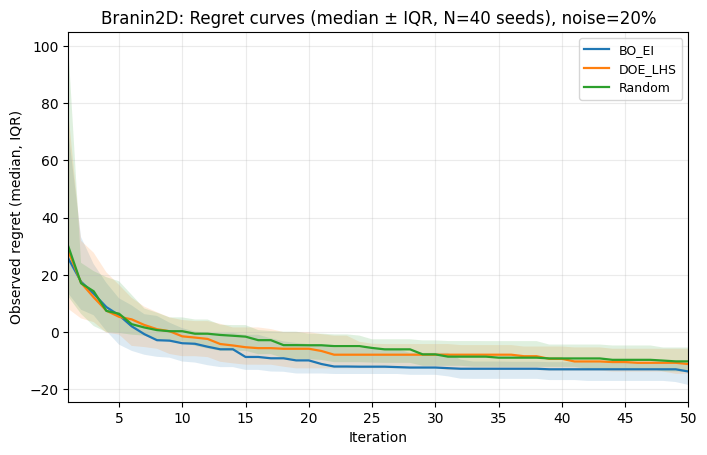

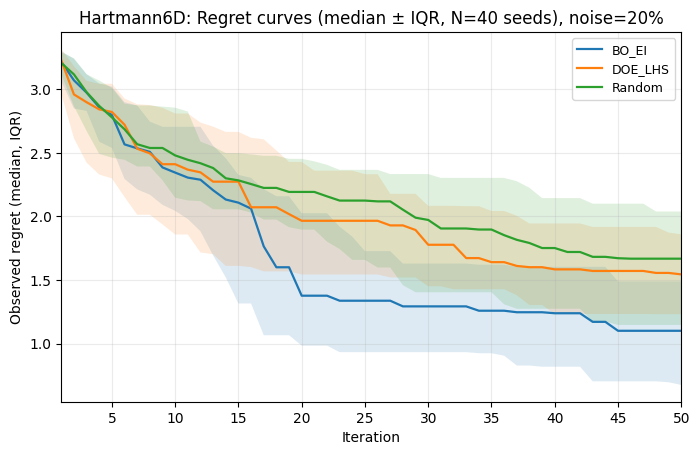

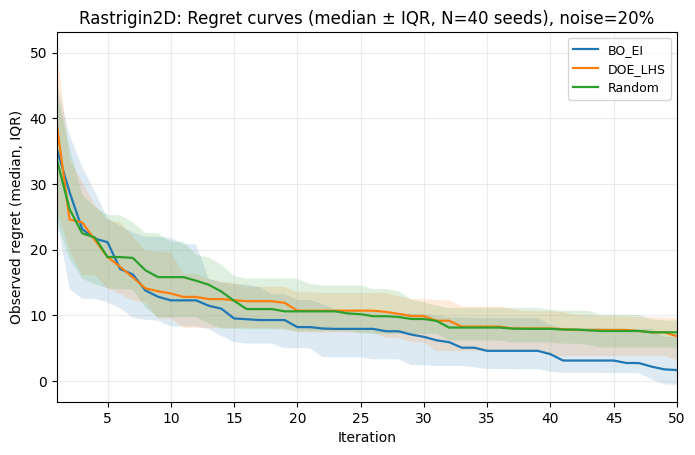

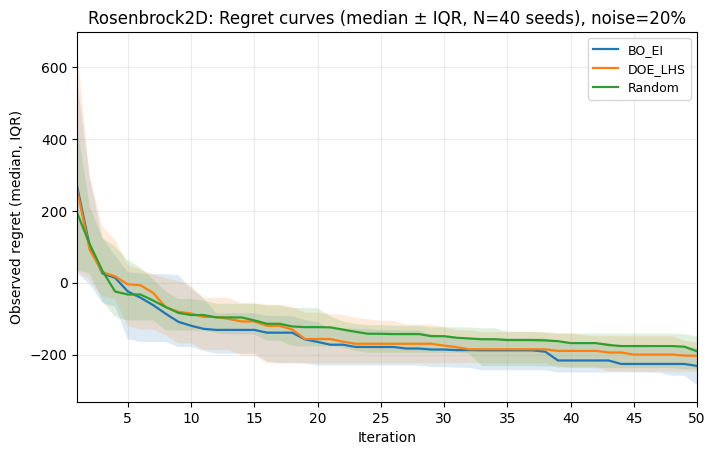

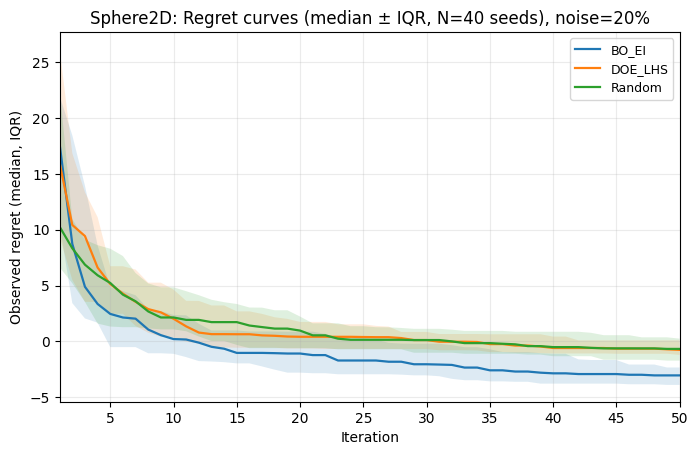

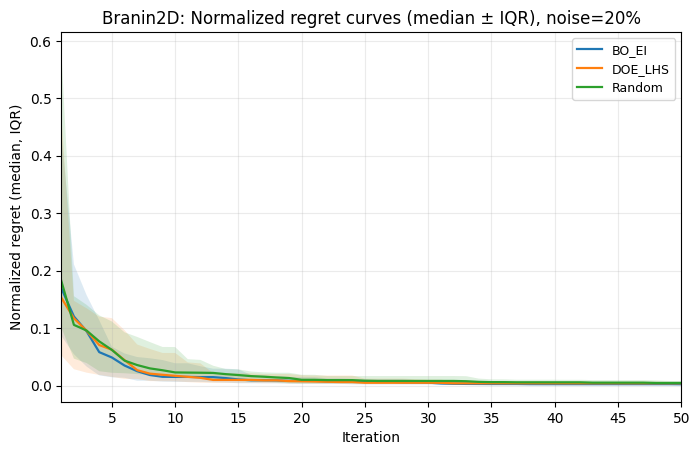

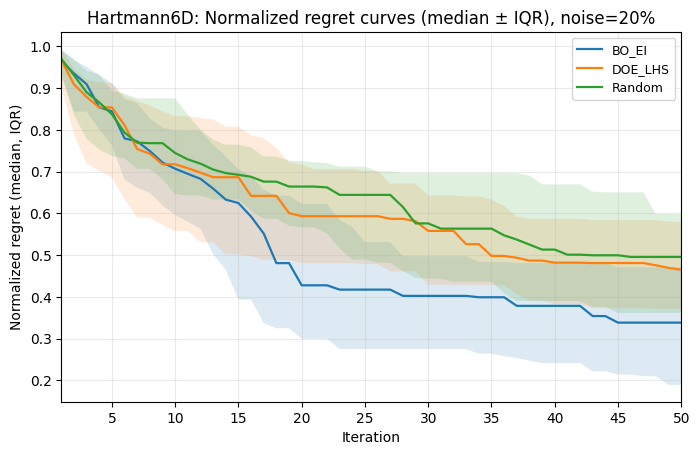

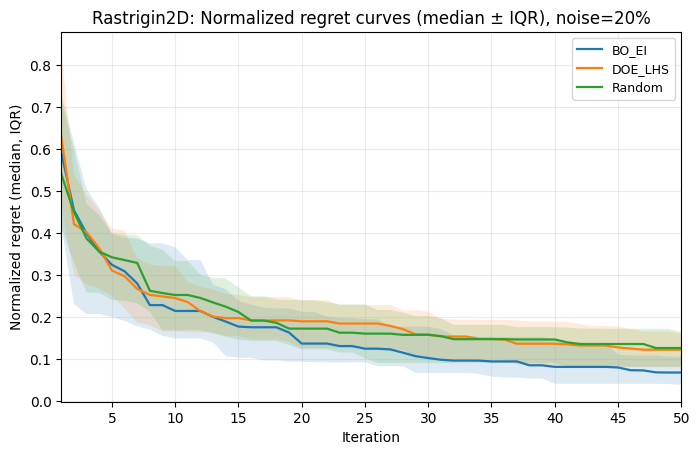

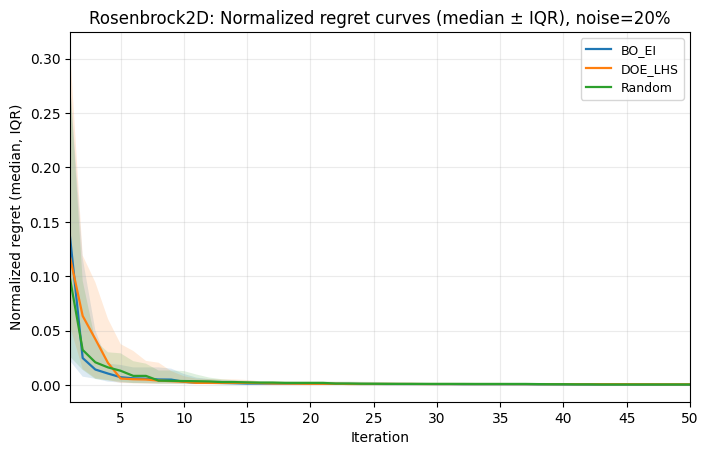

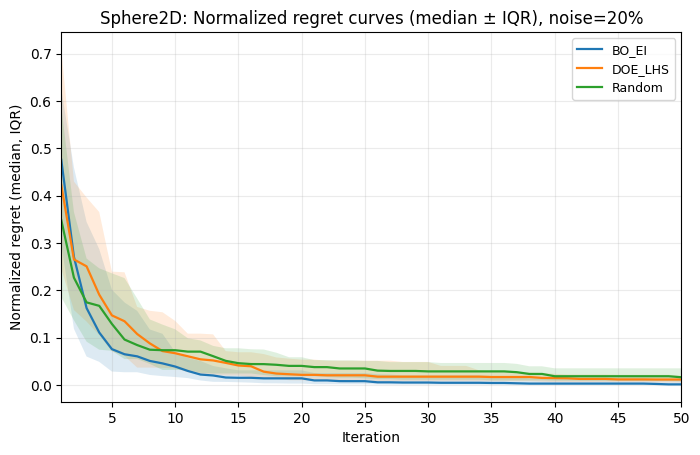

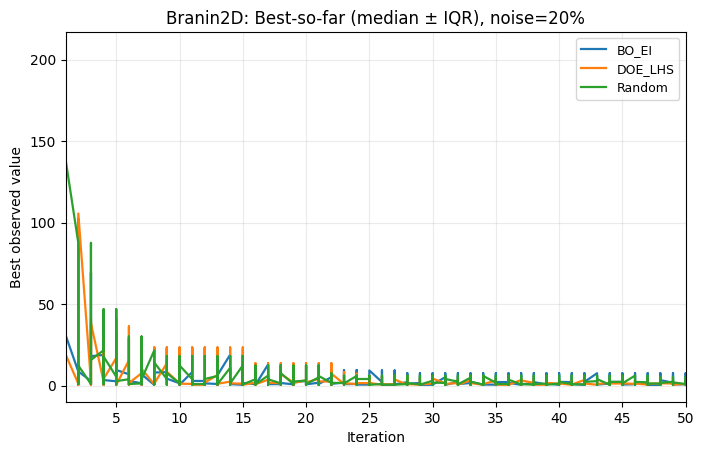

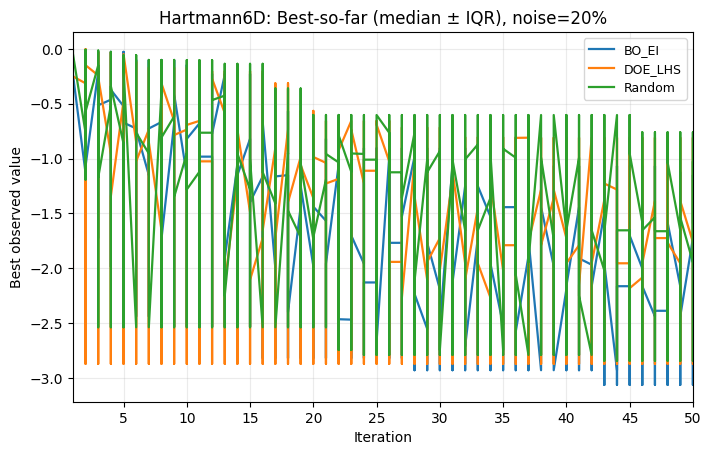

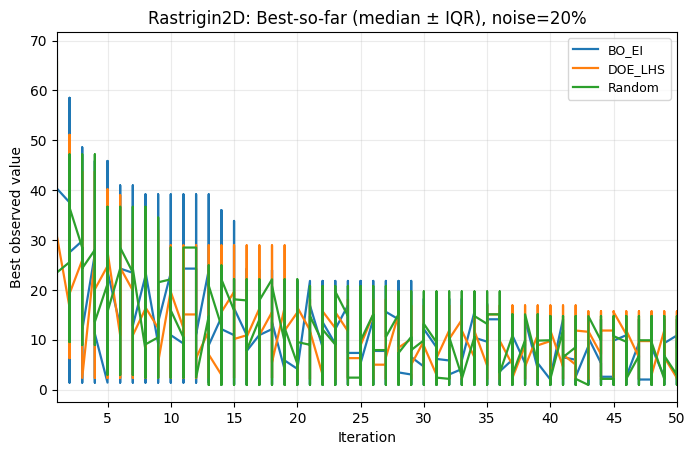

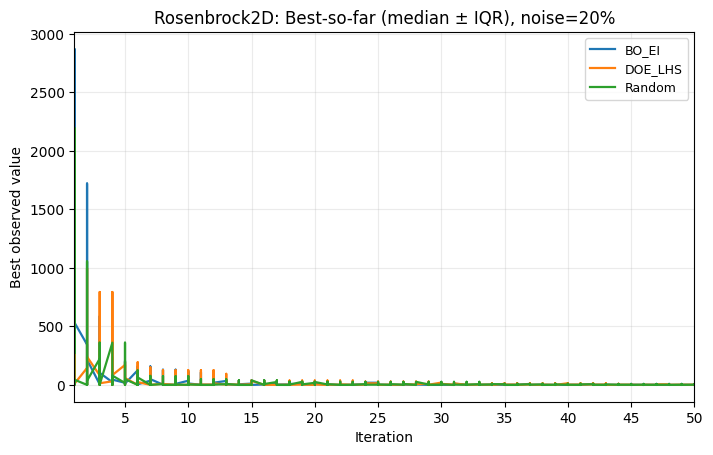

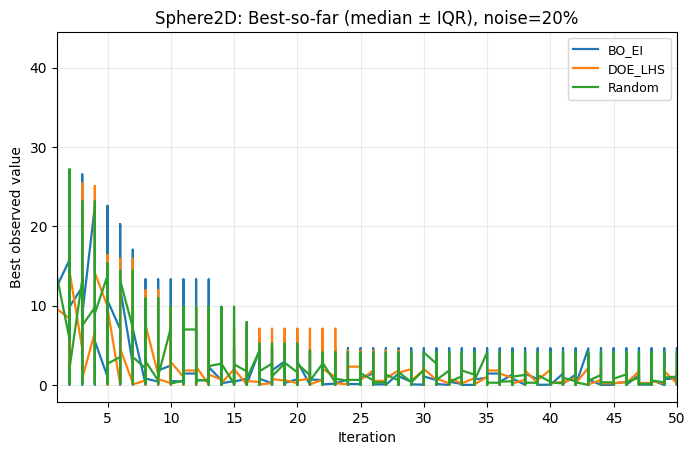

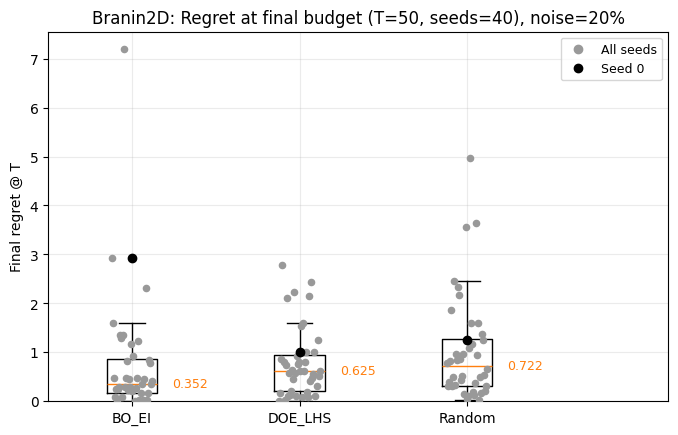

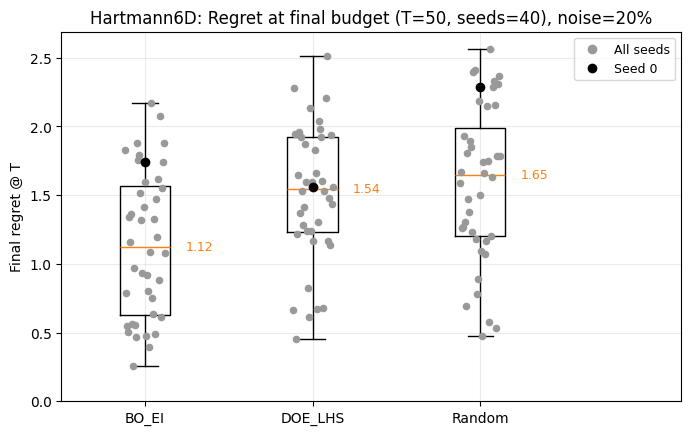

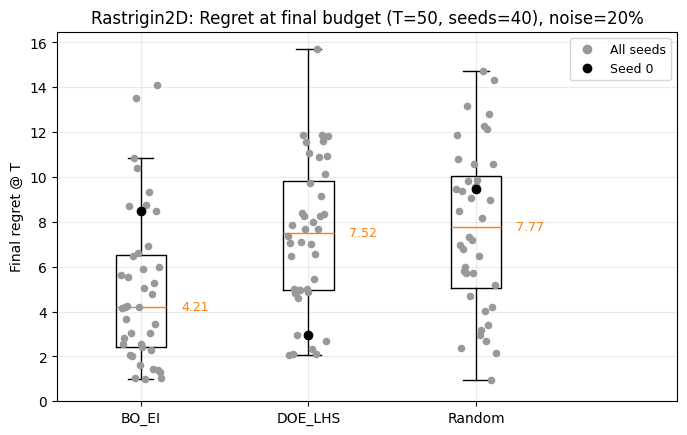

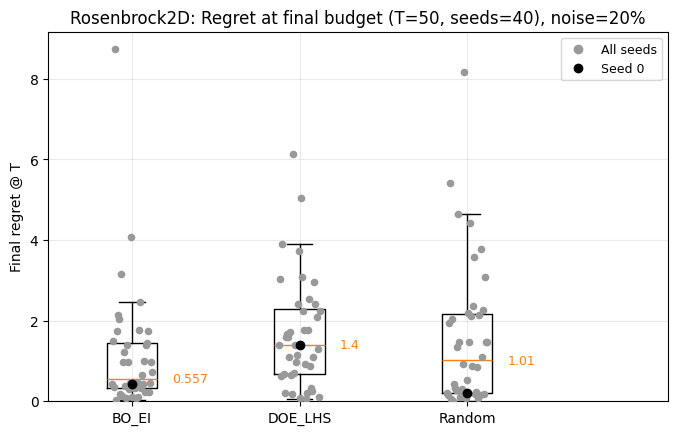

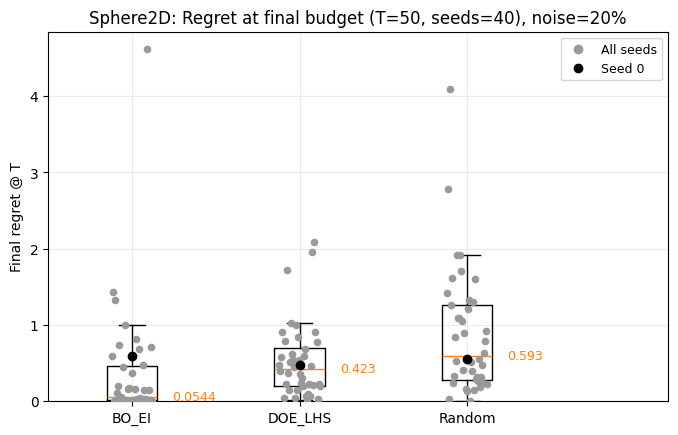

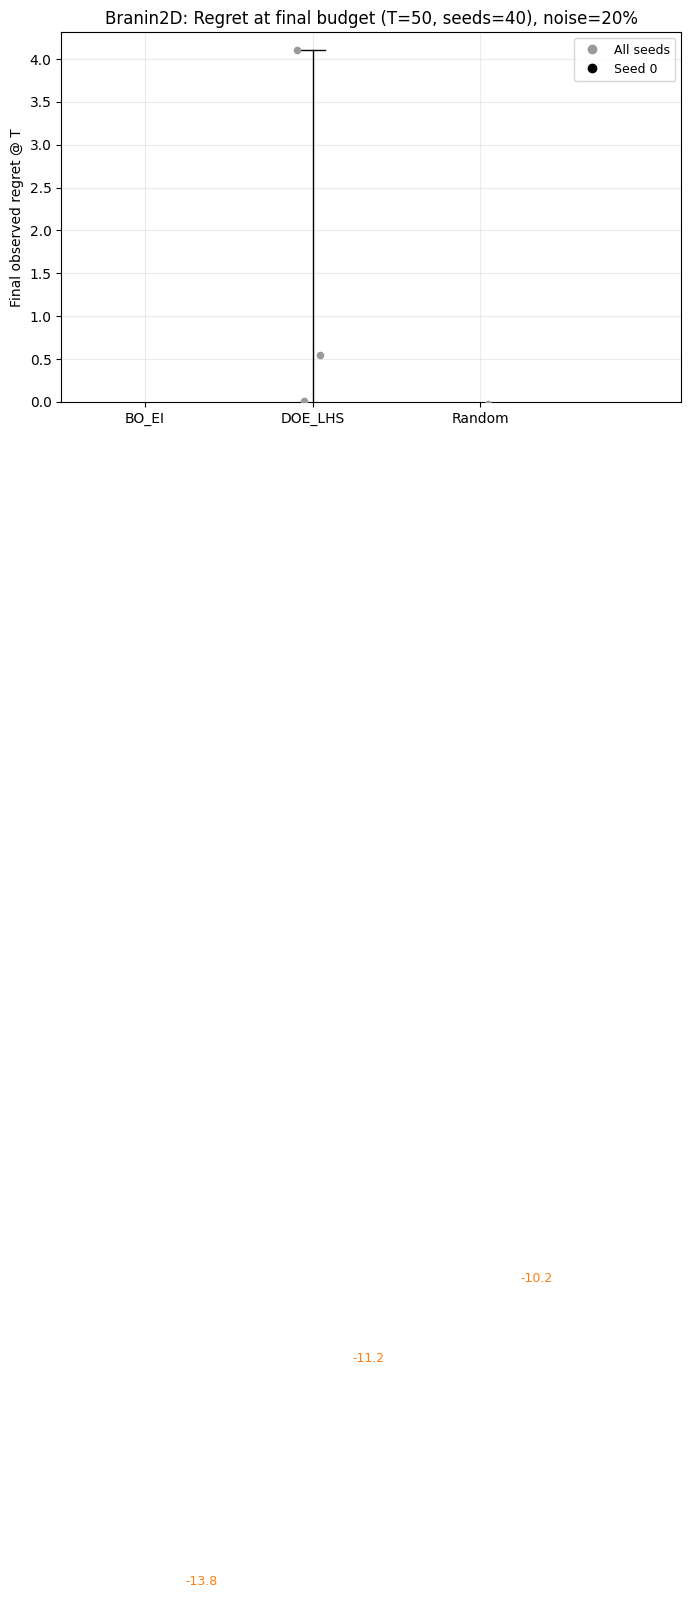

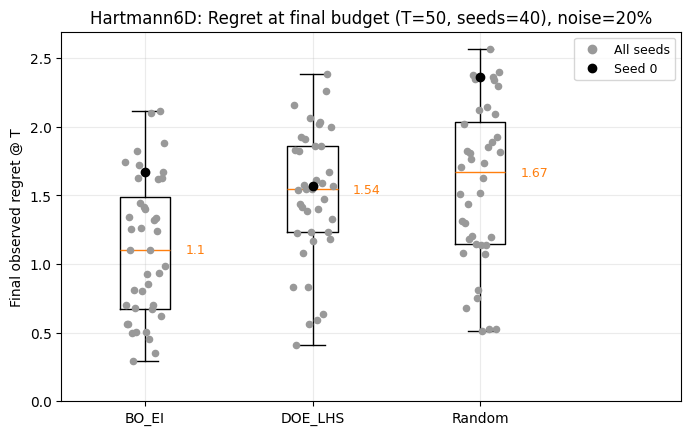

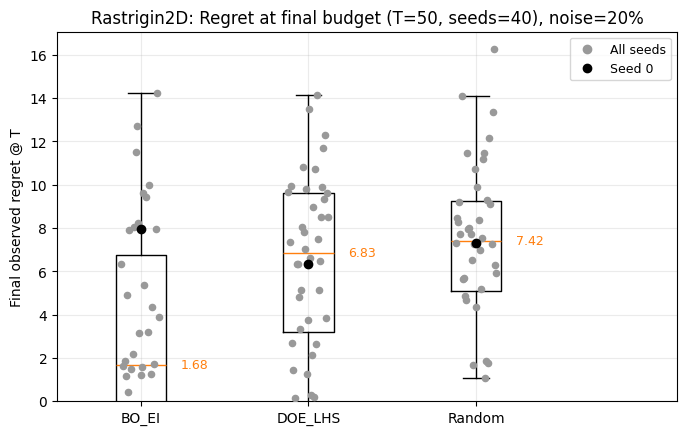

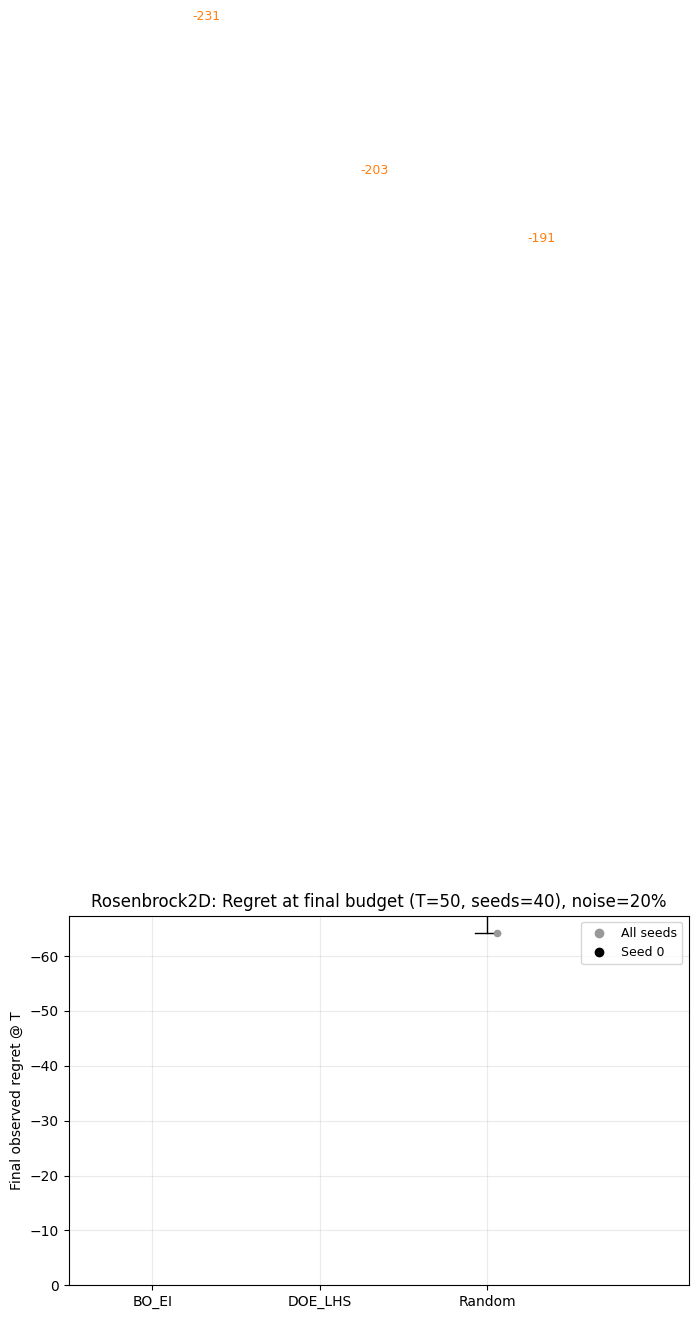

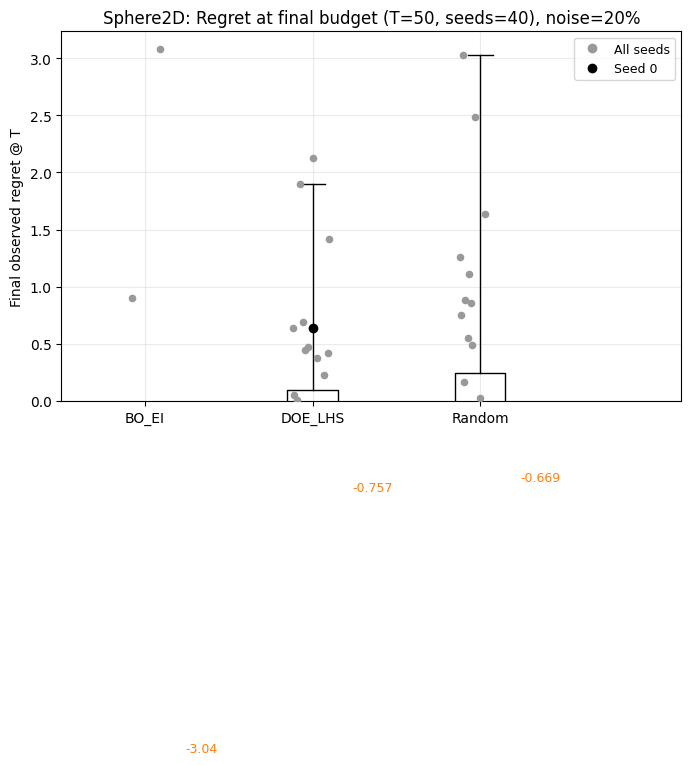

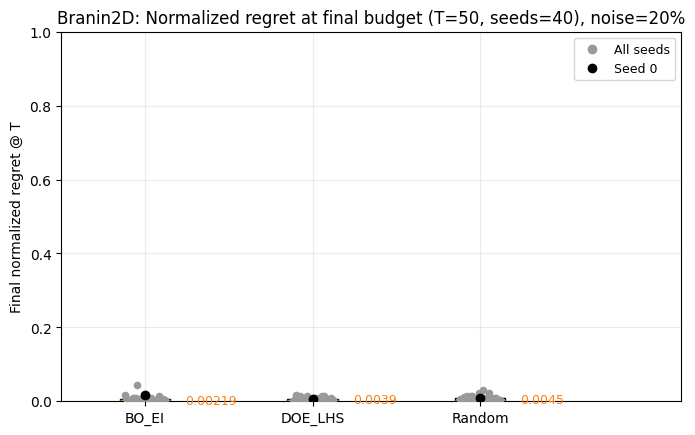

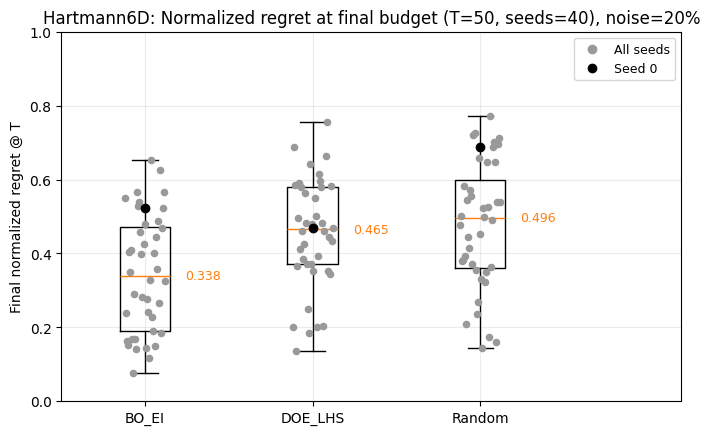

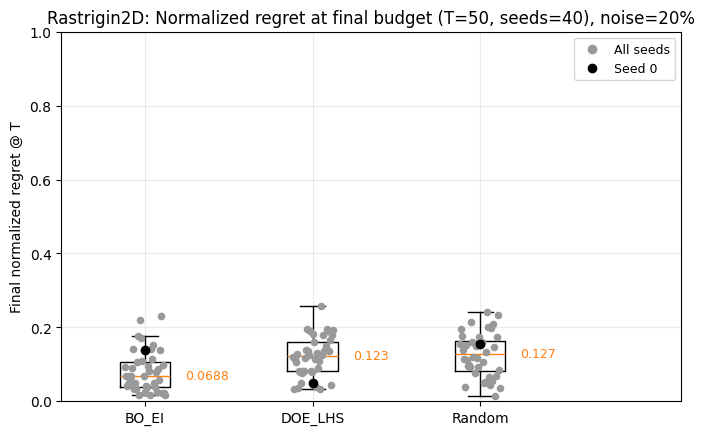

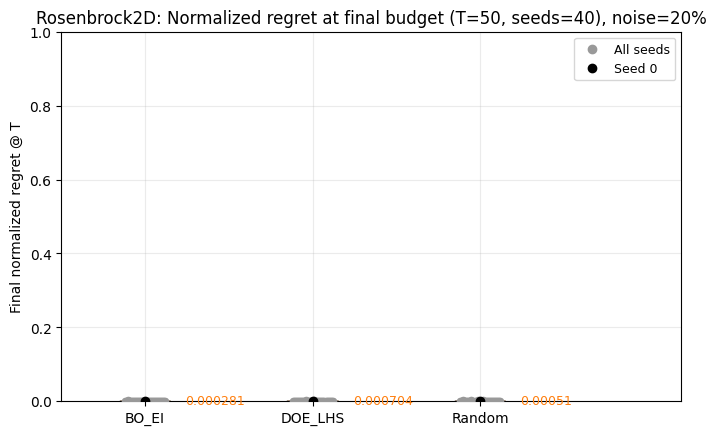

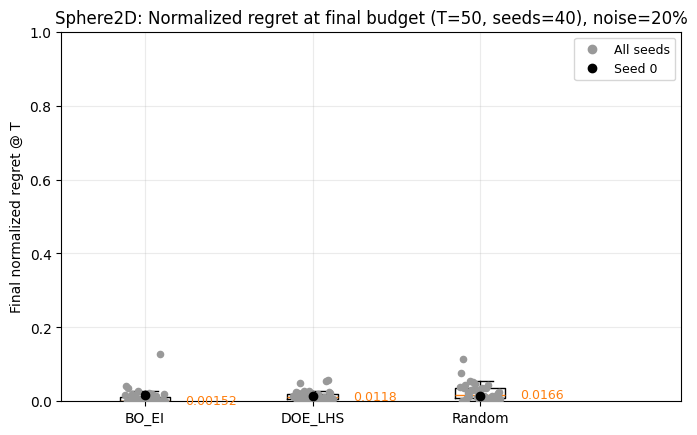

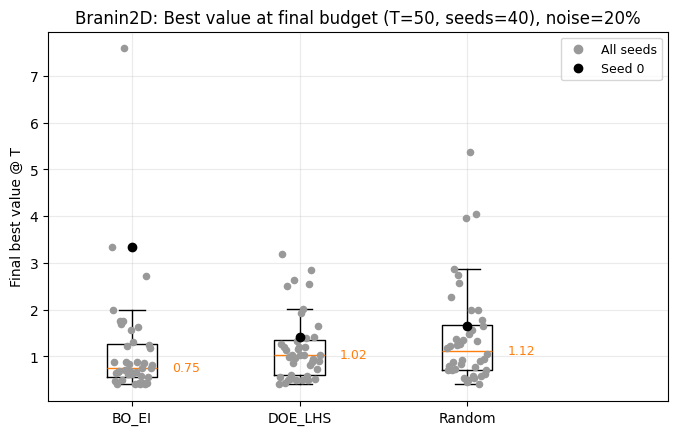

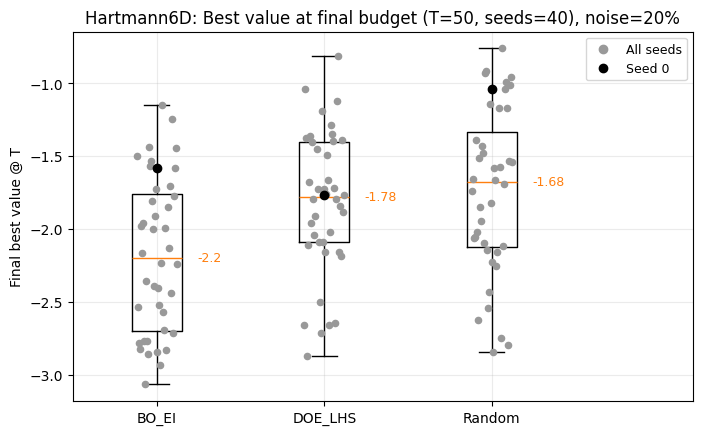

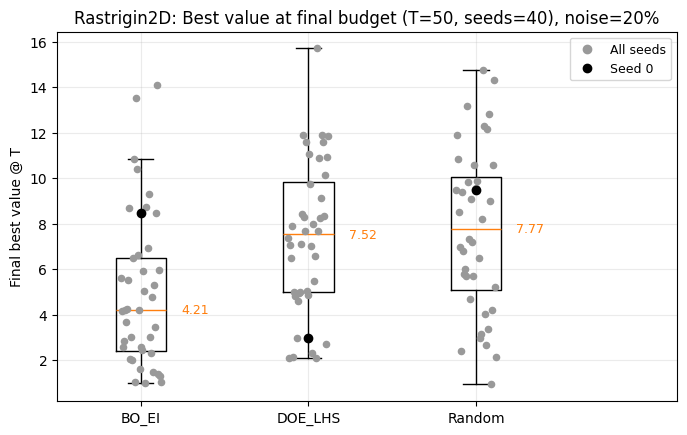

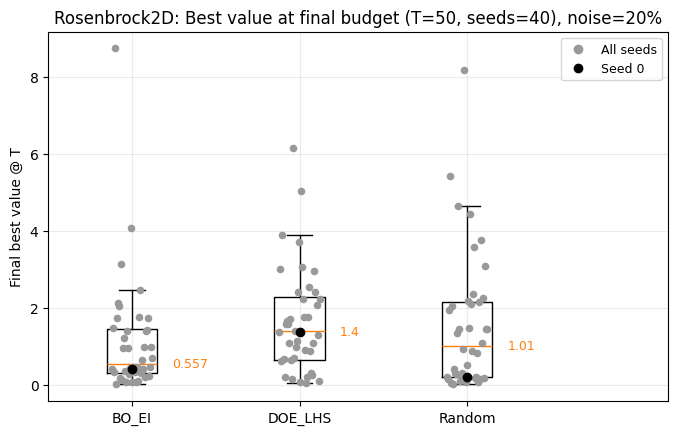

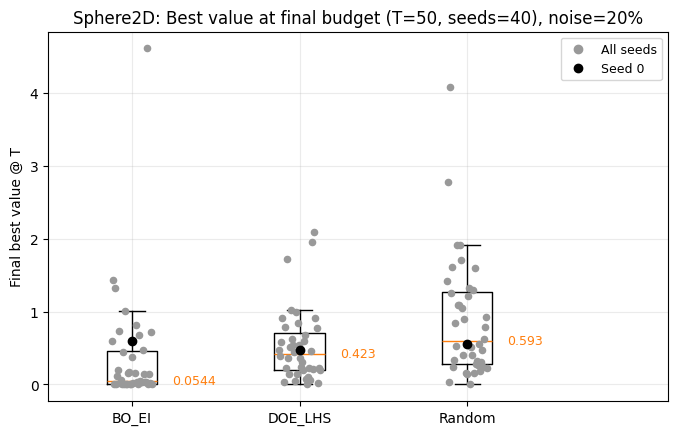

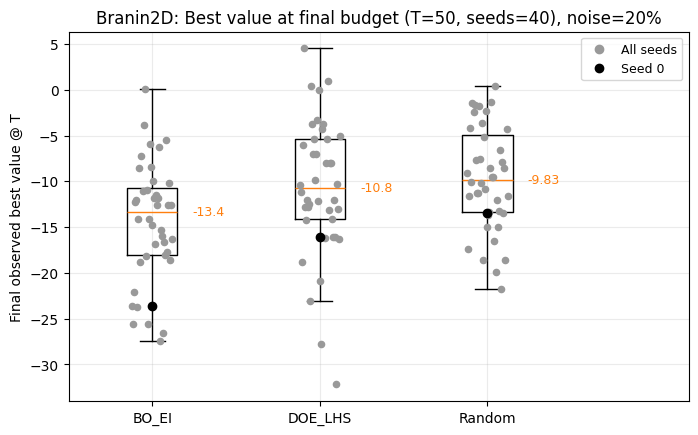

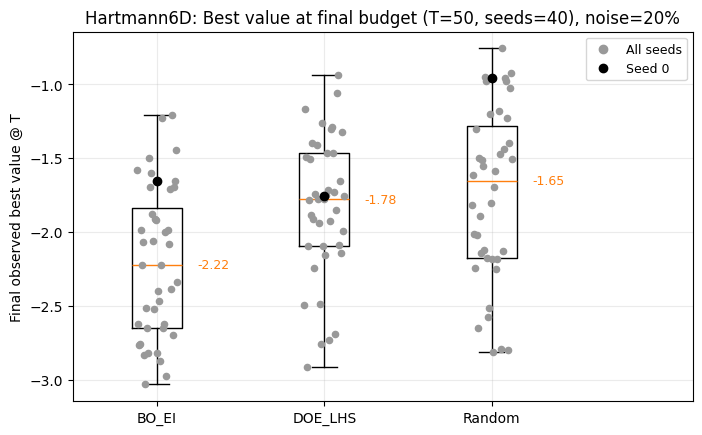

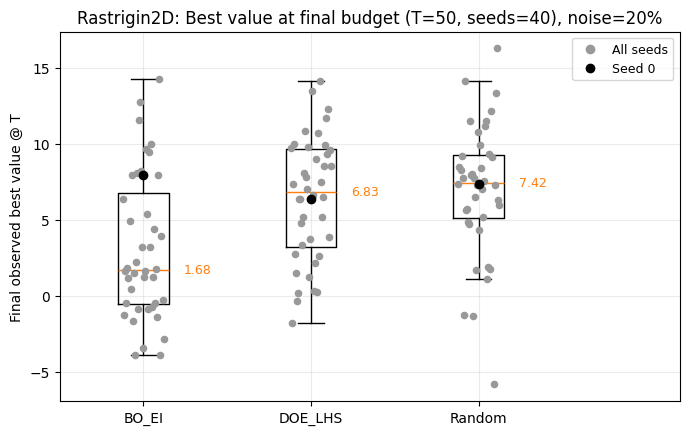

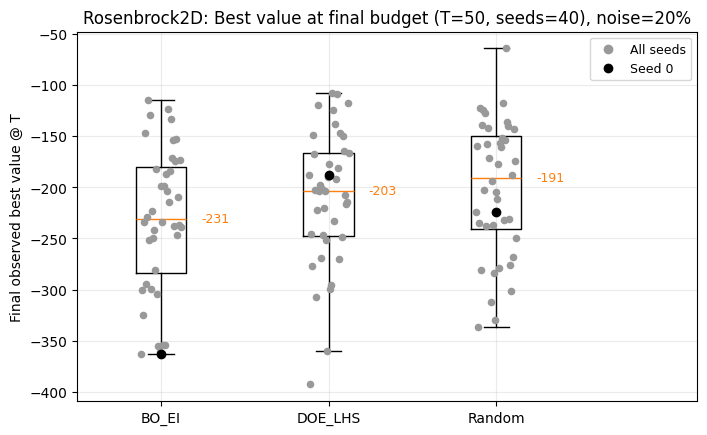

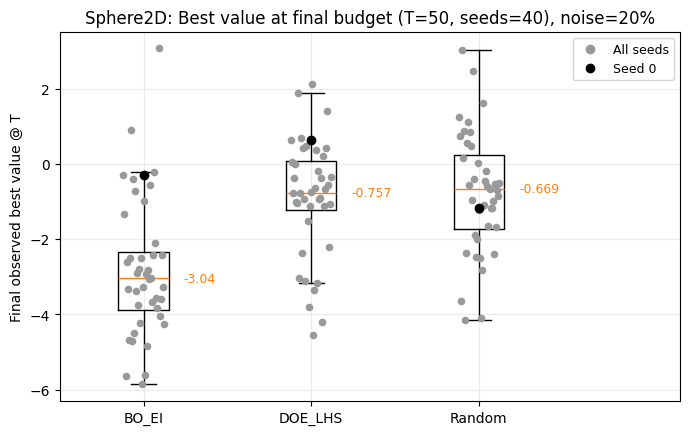

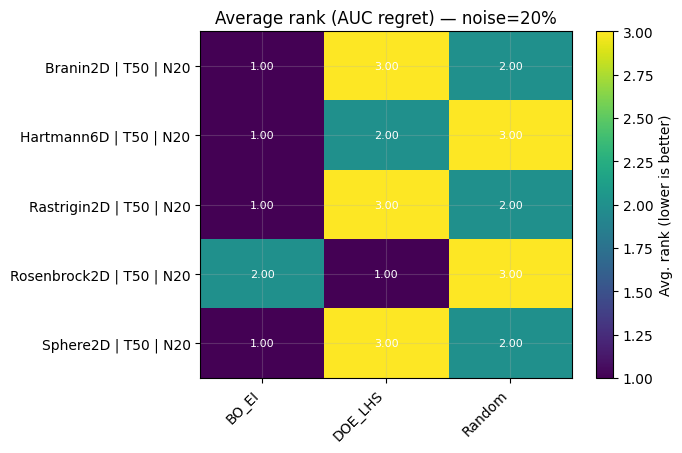

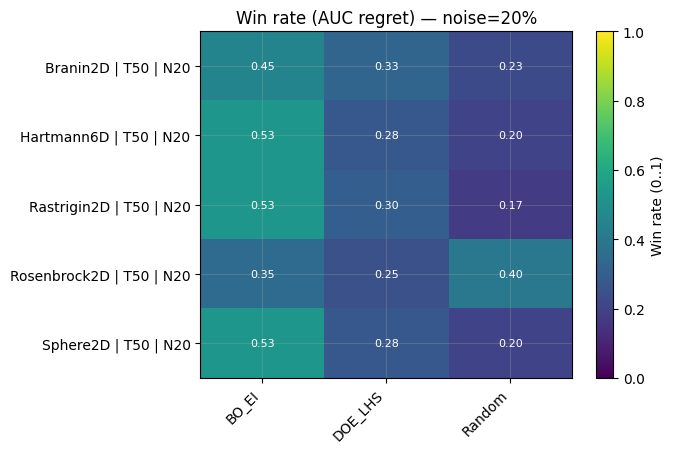

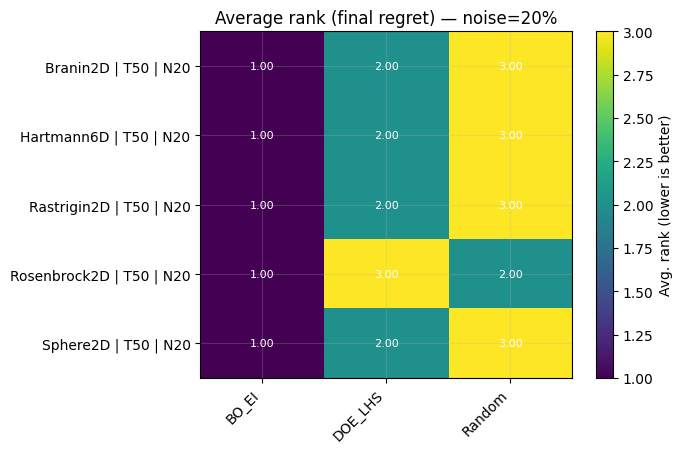

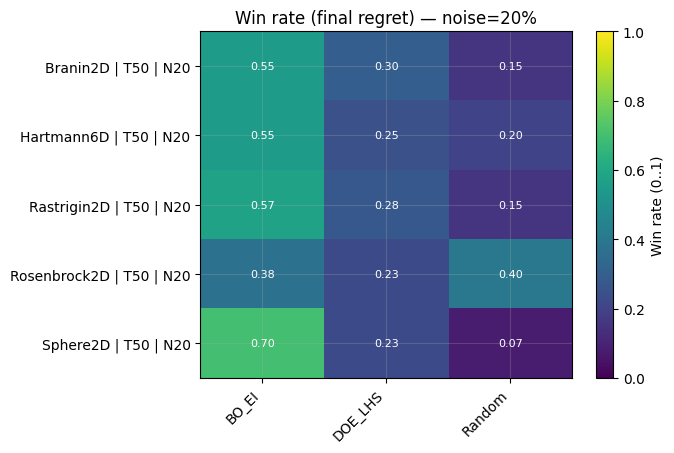

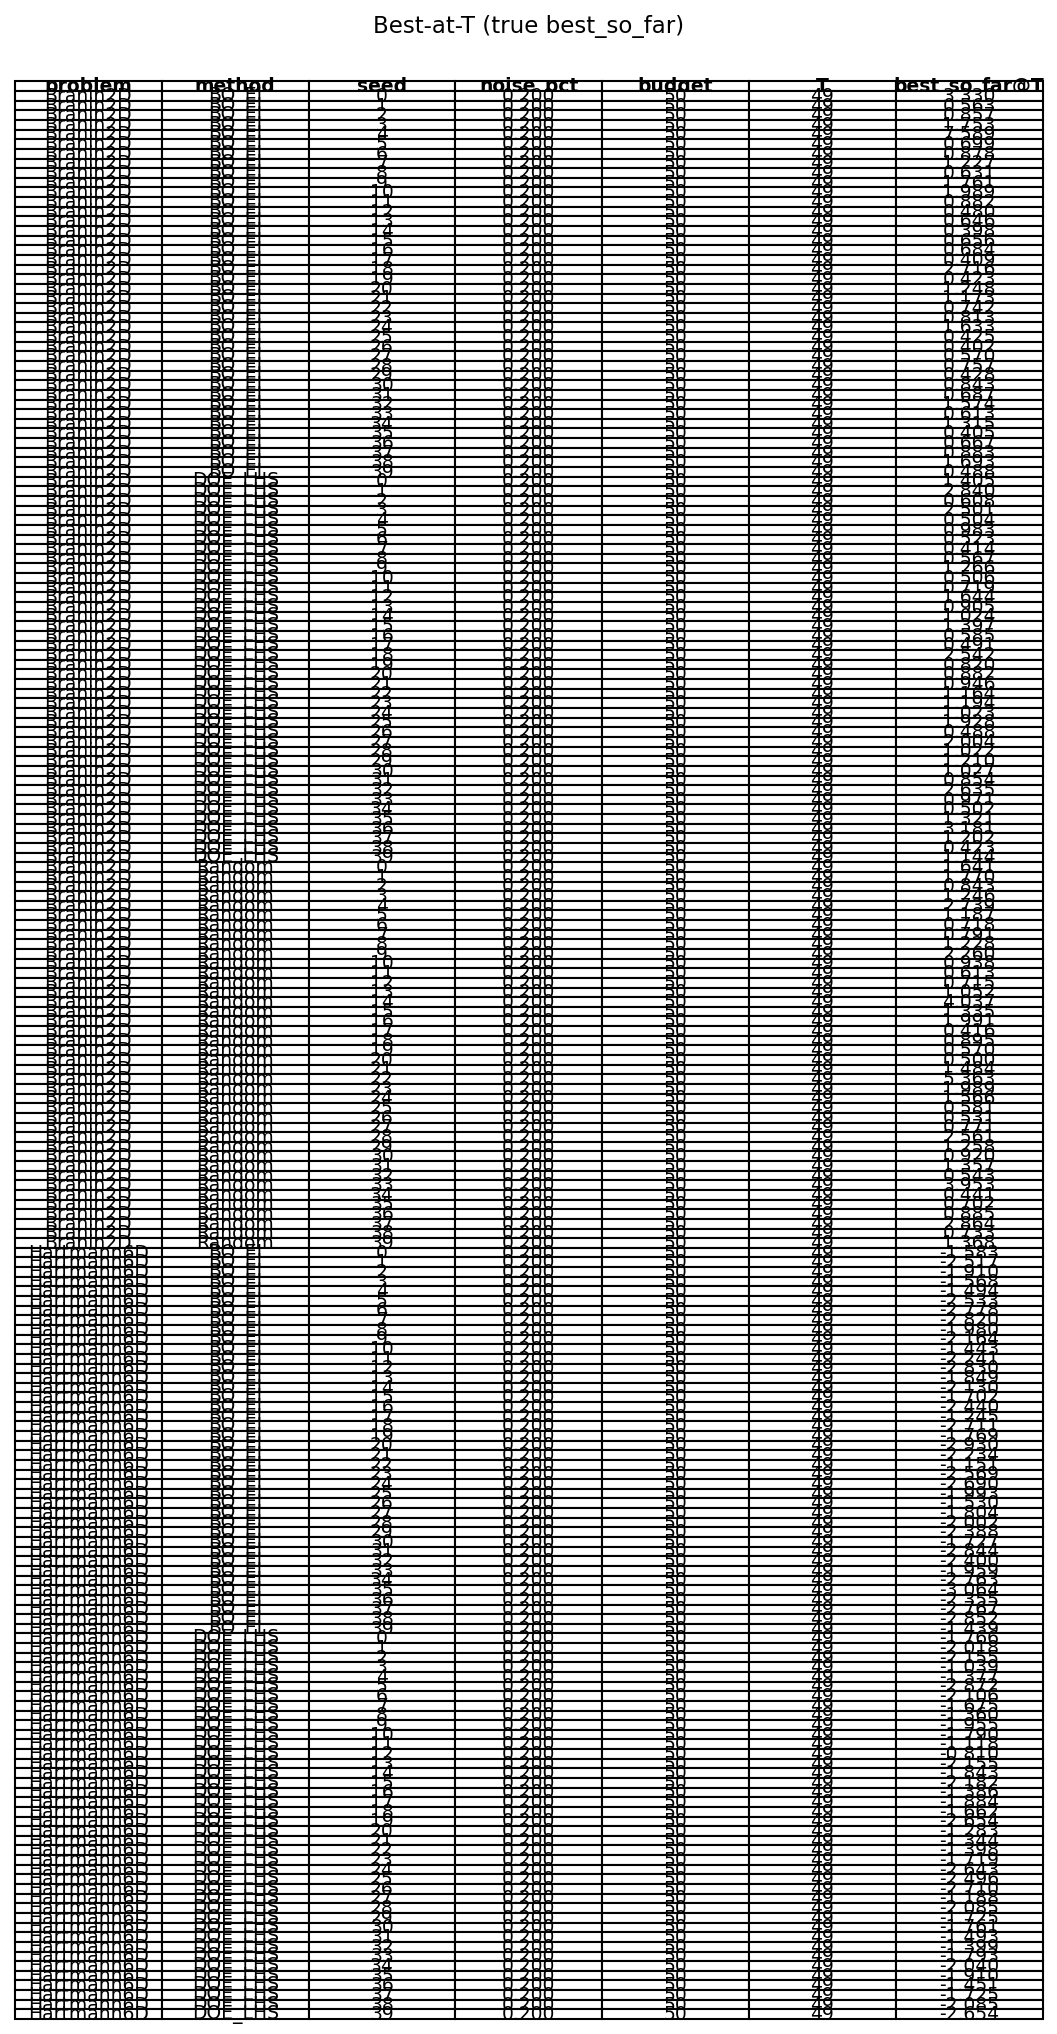

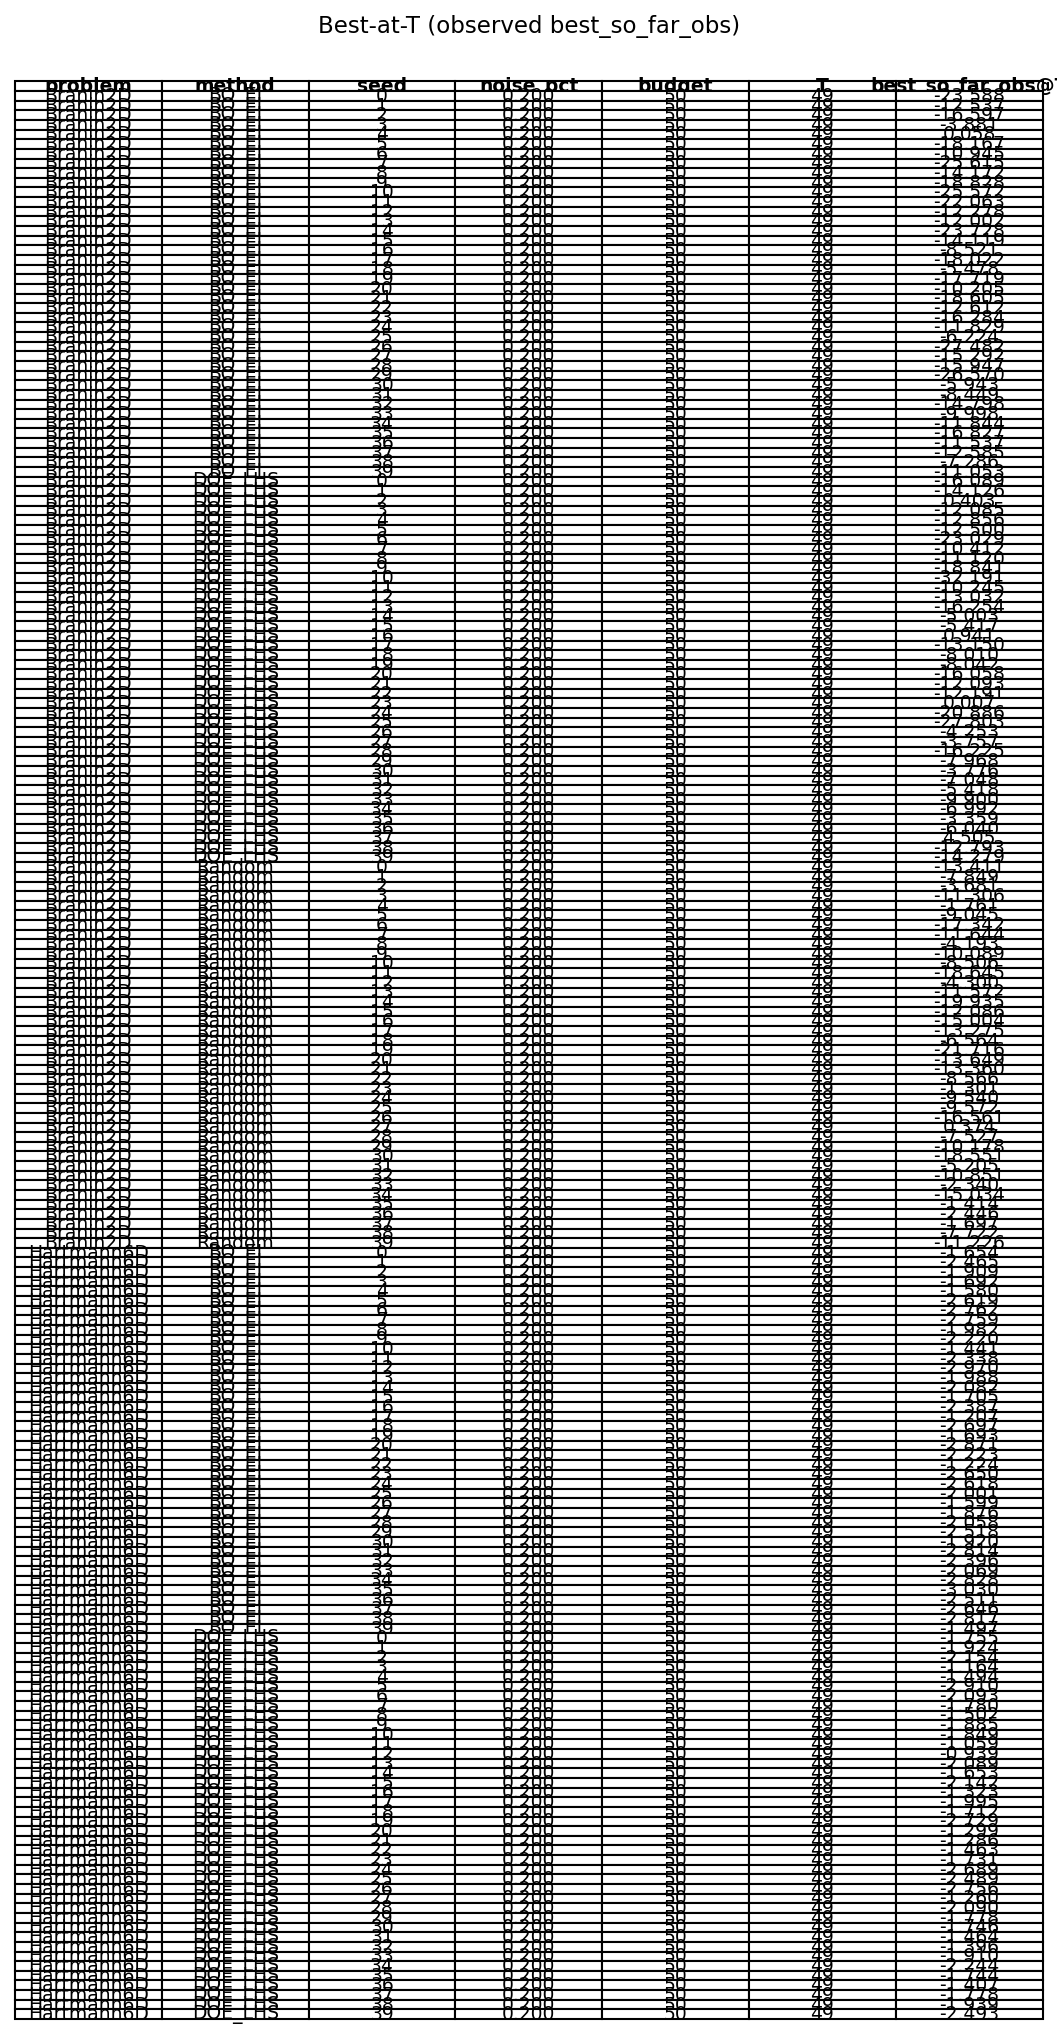

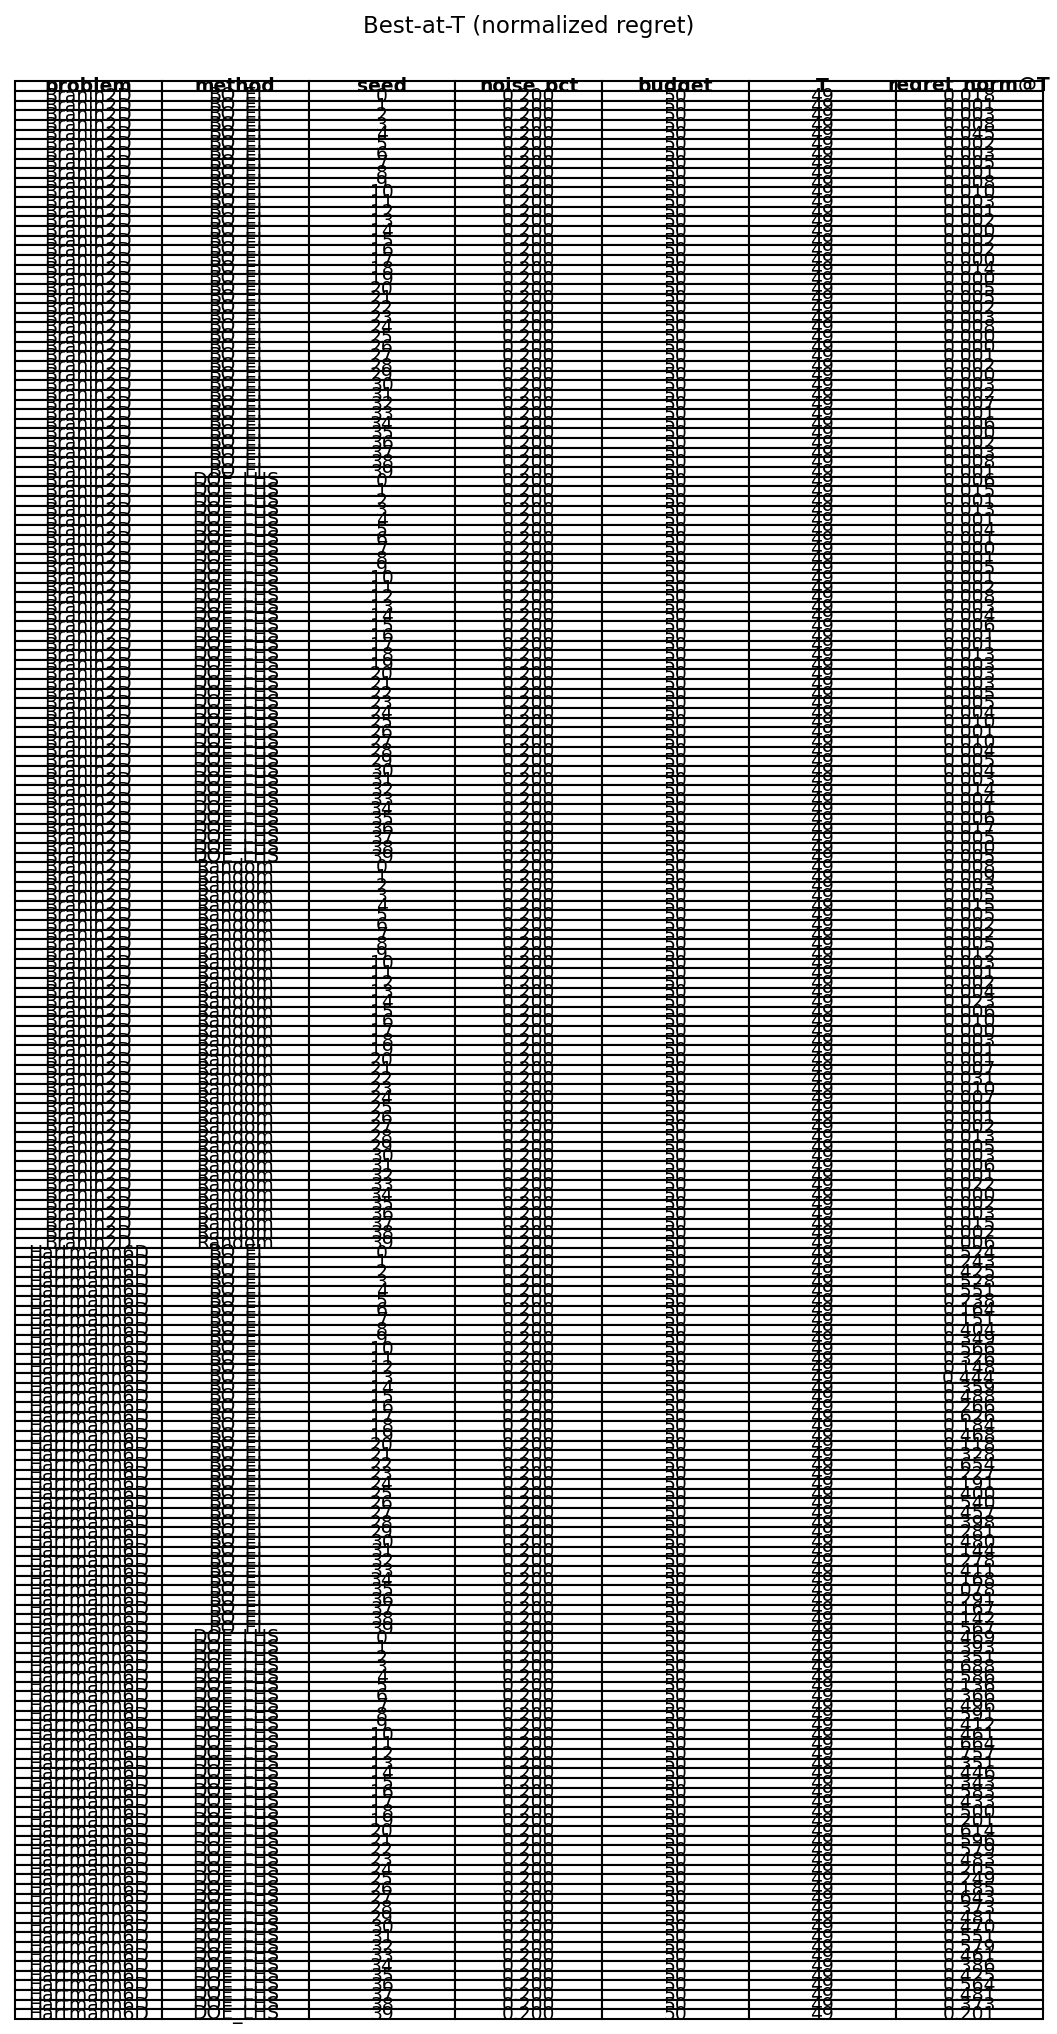

Table PNGs: {'true': 'results\\20251102_023234_SB7_Problem_class\\tables\\best_at_T_by_seed_method_true.png', 'obs': 'results\\20251102_023234_SB7_Problem_class\\tables\\best_at_T_by_seed_method_obs.png', 'norm': 'results\\20251102_023234_SB7_Problem_class\\tables\\best_at_T_by_seed_method_norm.png'}
[tables] generated 0 per-plot tables.
Report: results\20251102_023234_SB7_Problem_class\benchmark_report.html
[debug] all_runs shape: (30000, 21), columns: ['best_so_far', 'best_so_far_obs', 'budget', 'dim', 'exp_name', 'init_factor', 'iter', 'method', 'noise_pct', 'noise_seed', 'problem', 'regret', 'regret_obs', 'seed', 'sigma_noise', 'time_s', 'x', 'x_uv', 'x_xy', 'y', 'y_noisy']
Artifacts written to: results\20251102_023234_SB7_Problem_class


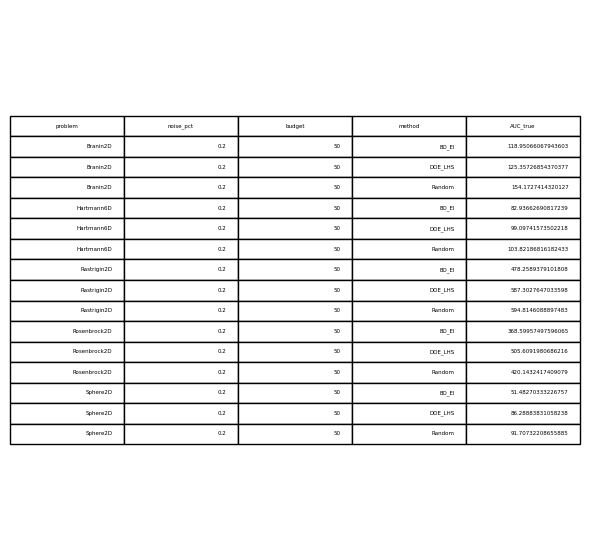

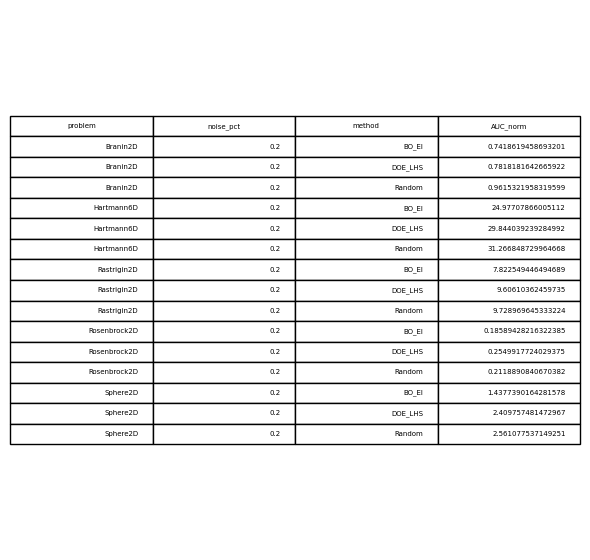

Artifacts written to: results\20251102_023234_SB7_Problem_class


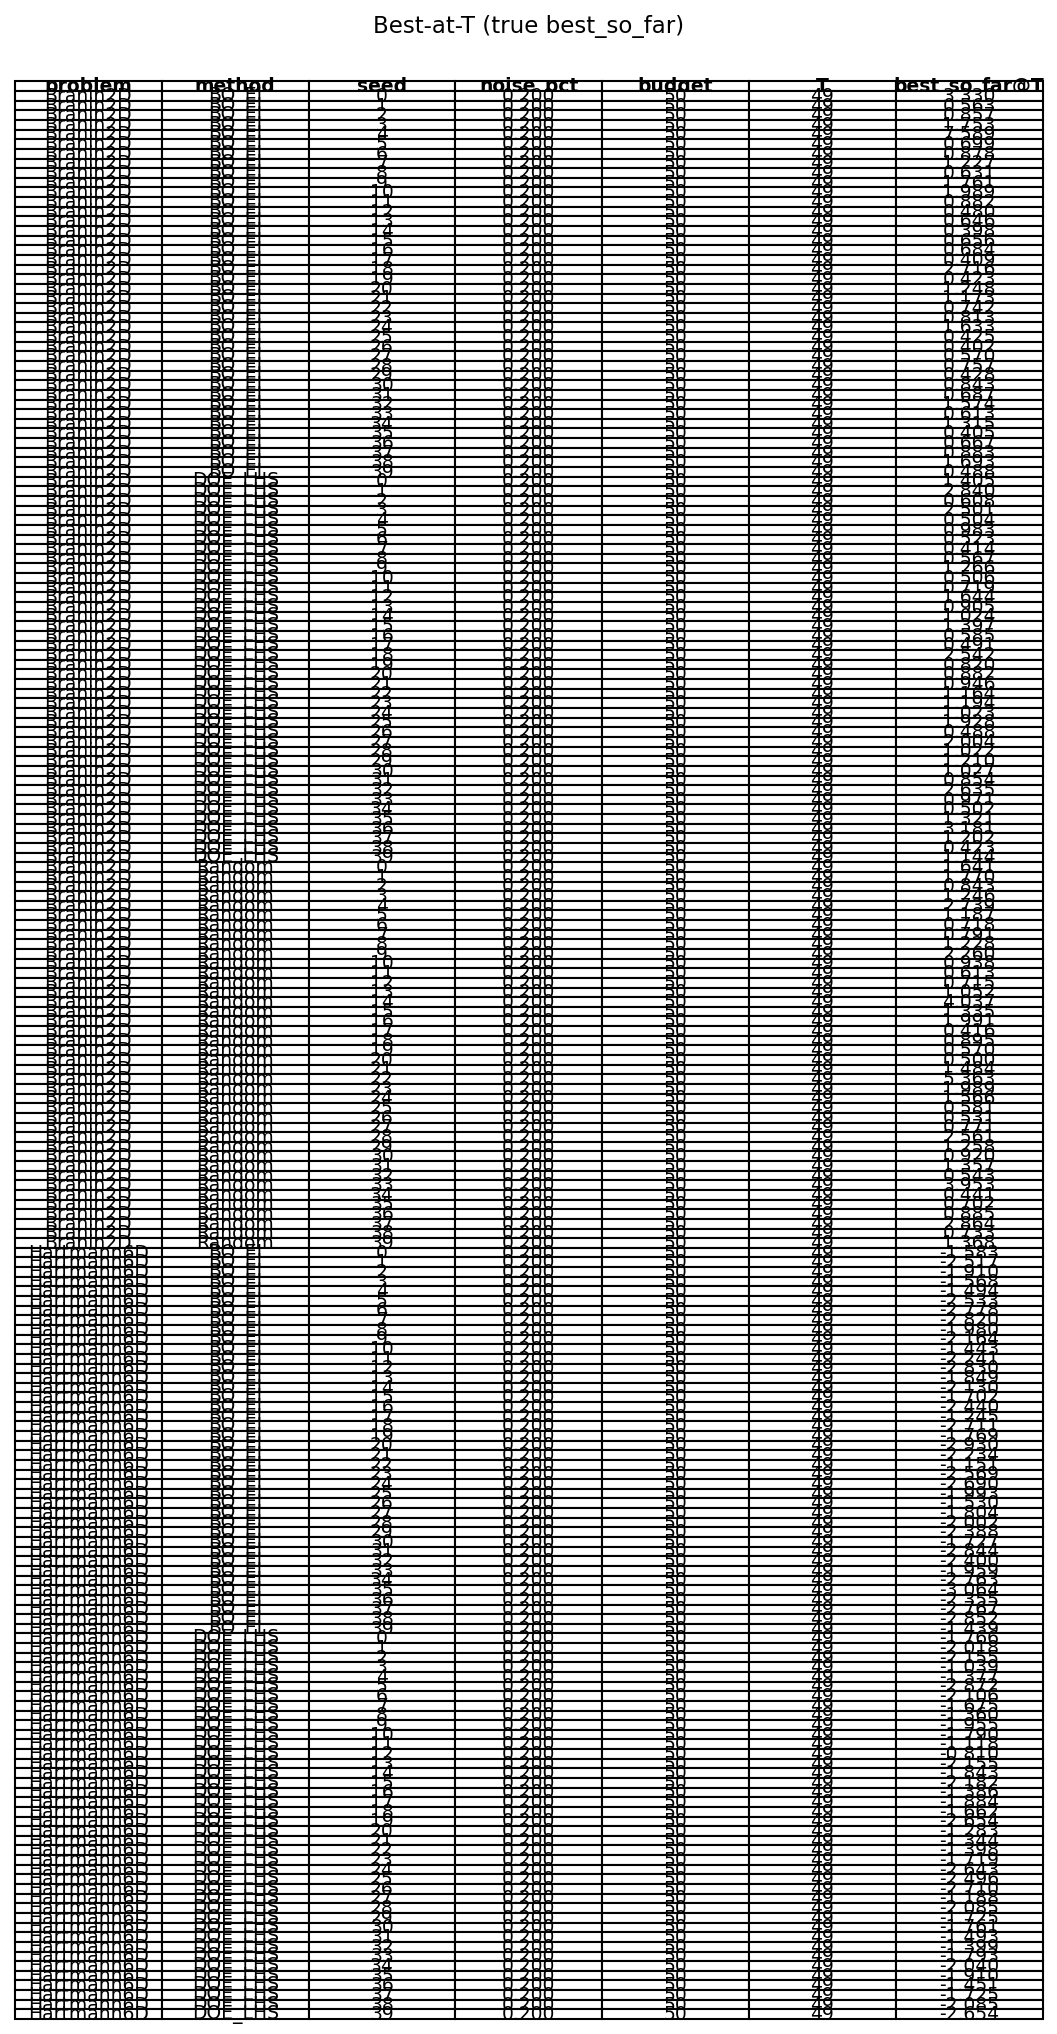

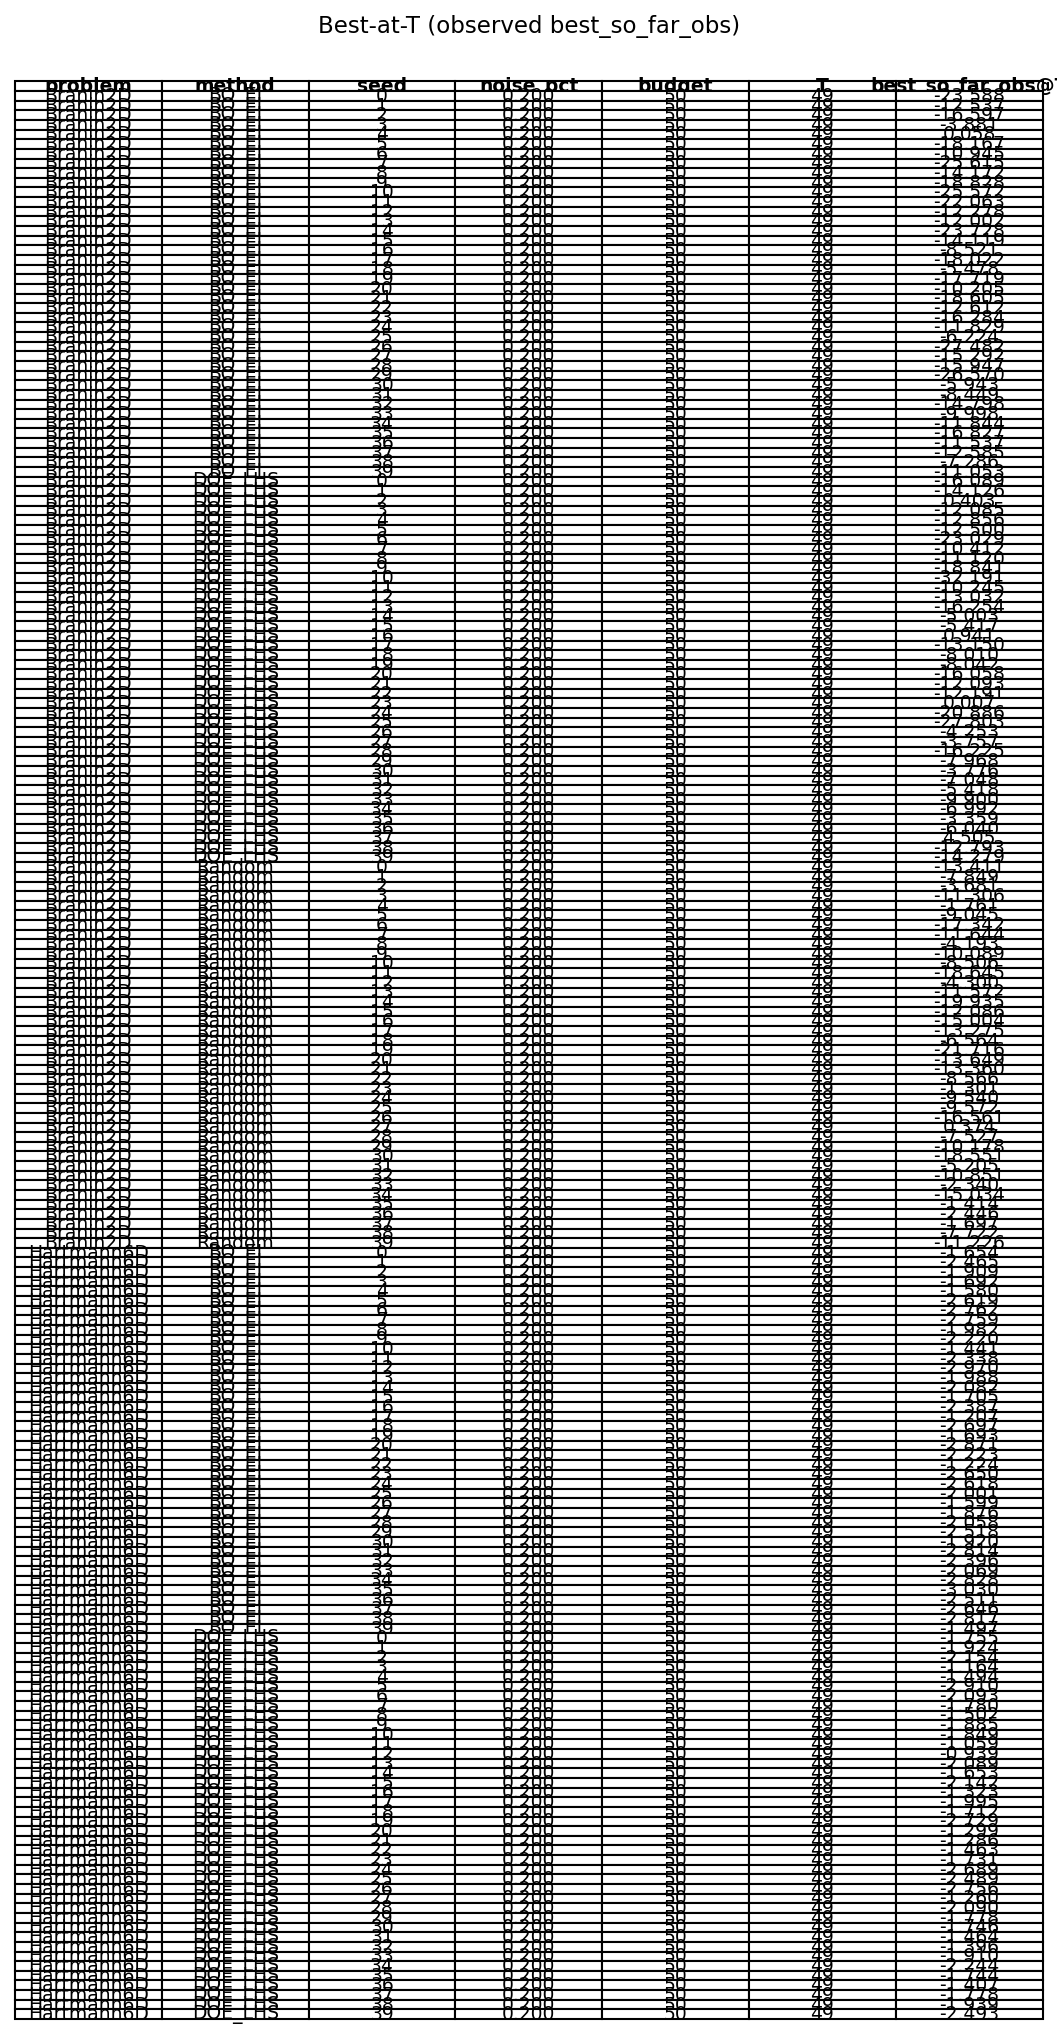

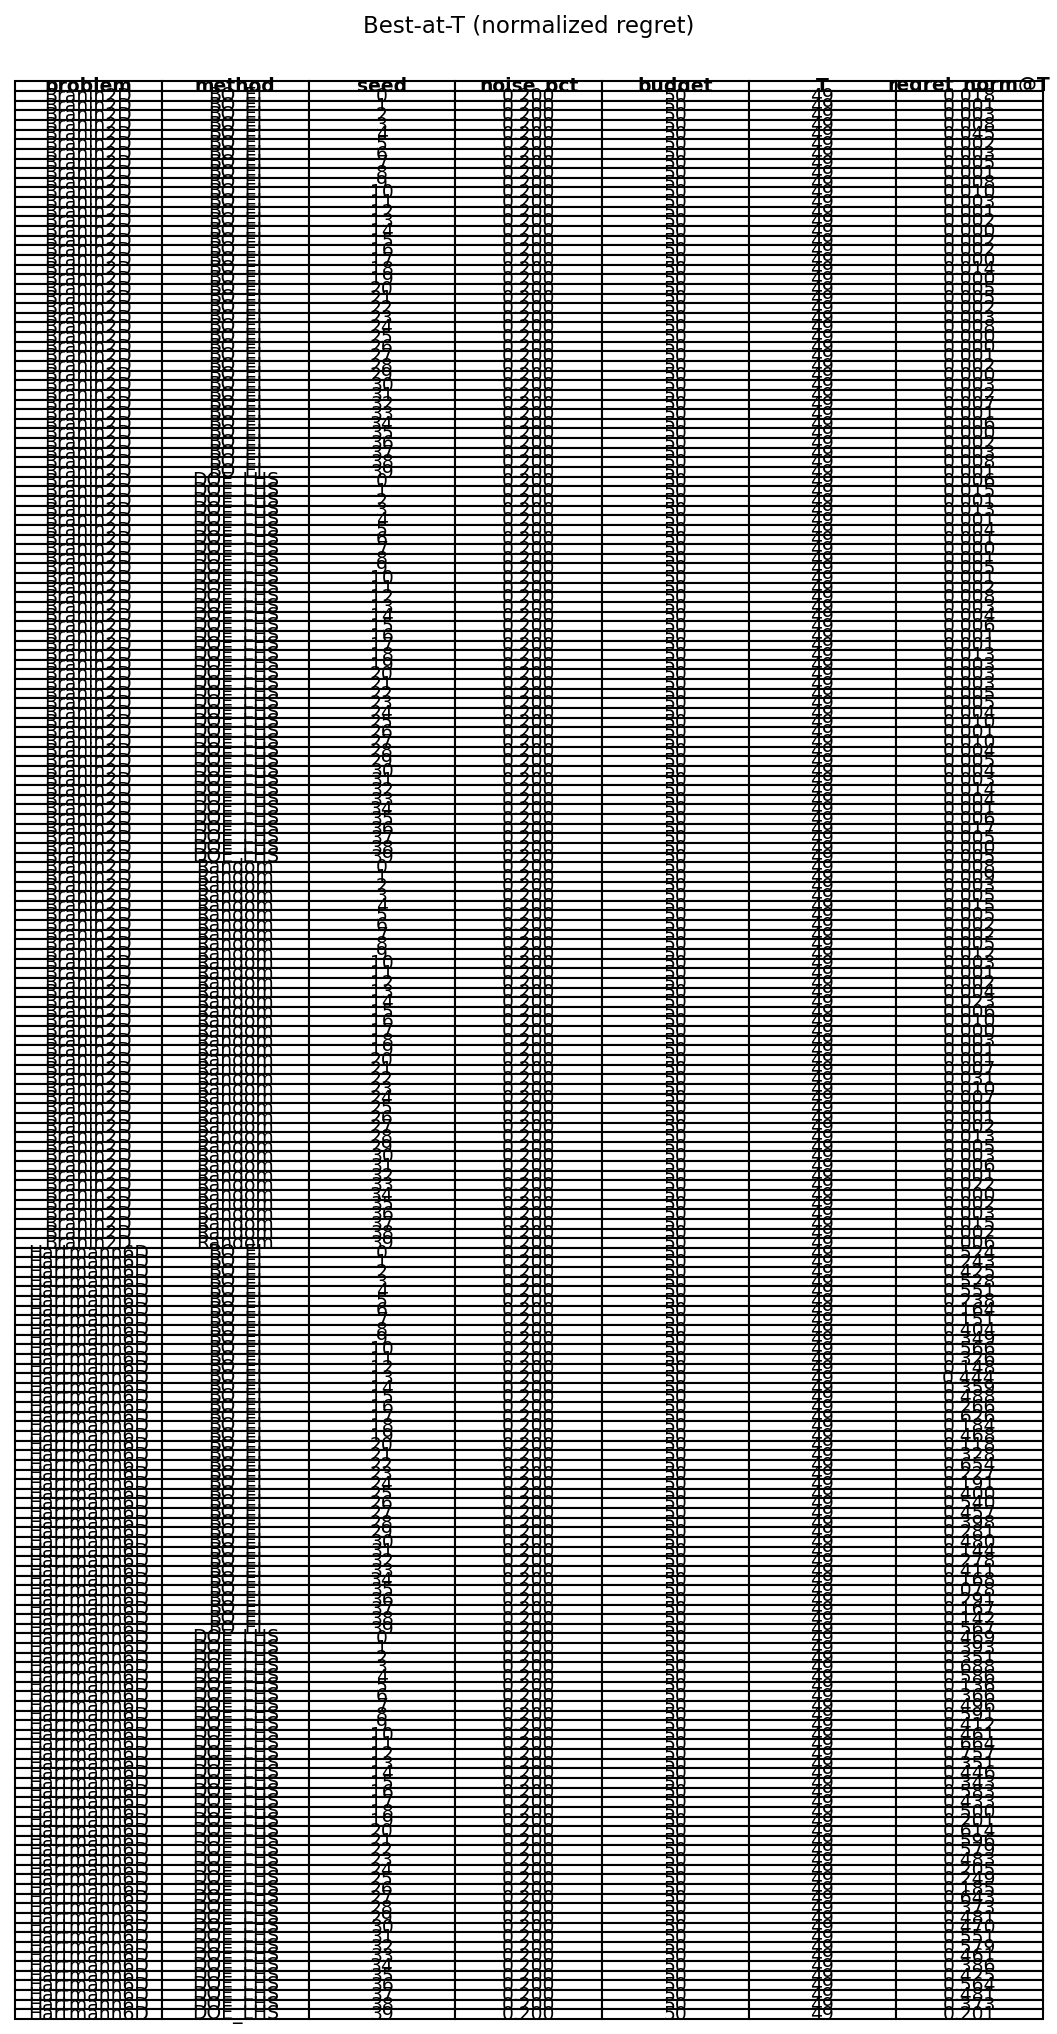

[tables] generated 0 per-plot tables.


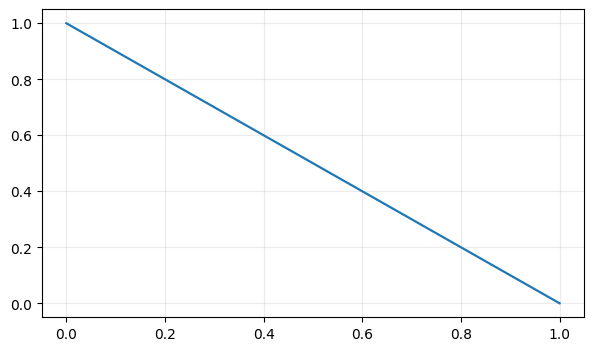

In [5]:
# Lauf ohne Inline-Rendern (verhindert Mega-Figures während des Runs)
outdir = sb6_run(run_and_collect, main.EXP_NAME)

# Plots später gezielt anzeigen:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot([0,1],[1,0])
sb6_show(fig)  # oder sb6_show_current()

In [6]:
show_all_core_plots(outdir)

In [7]:
show_core_dataframes(outdir)

all_runs.csv shape: (30000, 21)


**Final rows per run (for boxplots):**

exp_name      problem   method  dim  seed  noise_seed  \
49     SB7_Problem_class     Branin2D    BO_EI    2     0      777000   
99     SB7_Problem_class     Branin2D    BO_EI    2    10      777010   
149    SB7_Problem_class     Branin2D    BO_EI    2    11      777011   
199    SB7_Problem_class     Branin2D    BO_EI    2    12      777012   
249    SB7_Problem_class     Branin2D    BO_EI    2    13      777013   
299    SB7_Problem_class     Branin2D    BO_EI    2    14      777014   
349    SB7_Problem_class     Branin2D    BO_EI    2    15      777015   
399    SB7_Problem_class     Branin2D    BO_EI    2    16      777016   
28499  SB7_Problem_class     Sphere2D   Random    2    18      777018   
28799  SB7_Problem_class     Sphere2D   Random    2    23      777023   
28549  SB7_Problem_class     Sphere2D   Random    2    19      777019   
28599  SB7_Problem_class     Sphere2D   Random    2     1      777001   
28649  SB7_Problem_class     Sphere2D   Random    2    20      777020   
28699  SB7_Problem_class     Sphere2D   Random    2    21      777021   
28749  SB7_Problem_class     Sphere2D   Random    2    22      777022   
29999  SB7_Problem_class     Sphere2D   Random    2     9      777009   
14249  SB7_Problem_class  Rastrigin2D  DOE_LHS    2    13      777013   
14299  SB7_Problem_class  Rastrigin2D  DOE_LHS    2    14      777014   
14349  SB7_Problem_class  Rastrigin2D  DOE_LHS    2    15      777015   
14399  SB7_Problem_class  Rastrigin2D  DOE_LHS    2    16      777016   

       noise_pct  sigma_noise  budget  iter  ...  \
49           0.2    10.282938      50    49  ...   
99           0.2    10.172826      50    49  ...   
149          0.2    10.339949      50    49  ...   
199          0.2    10.409822      50    49  ...   
249          0.2    10.152264      50    49  ...   
299          0.2    10.348178      50    49  ...   
349          0.2    10.353459      50    49  ...   
399          0.2    10.305344      50    49  ...   
28499        0.2     2.116607      50    49  ...   
28799        0.2     2.107007      50    49  ...   
28549        0.2     2.157176      50    49  ...   
28599        0.2     2.120499      50    49  ...   
28649        0.2     2.102545      50    49  ...   
28699        0.2     2.118592      50    49  ...   
28749        0.2     2.079498      50    49  ...   
29999        0.2     2.132802      50    49  ...   
14249        0.2     2.804863      50    49  ...   
14299        0.2     2.859102      50    49  ...   
14349        0.2     2.827513      50    49  ...   
14399        0.2     2.866641      50    49  ...   

                                              x_uv  \
49      [0.48240569423775526, 0.11980788040756996]   
99     [0.06234255507120012, 0.014771084945037649]   
149      [0.9999144734531826, 0.36896607794890046]   
199    [0.34771452726229657, 0.020718419759098272]   
249       [0.554032516971693, 0.11896021754042818]   
299      [0.12879099128149474, 0.7651599607232856]   
349      [0.10938475575826478, 0.7933546610752978]   
399      [0.9817207503206348, 0.26133892218315635]   
28499      [0.8039910048320532, 0.998464832903346]   
28799      [0.846605037907451, 0.7767707636398414]   
28549     [0.9631517616308489, 0.8045899387965214]   
28599    [0.38042426988653233, 0.7252939380762389]   
28649     [0.8669628705667157, 0.7694409646682246]   
28699     [0.2765756179487656, 0.8120962210776497]   
28749     [0.32959878913505825, 0.849757296986235]   
29999     [0.3115337102174045, 0.2185536641978828]   
14249    [0.29934590555583174, 0.8956380318657817]   
14299    [0.5989694221102791, 0.40367934410368556]   
14349      [0.916578210423209, 0.9841933741371519]   
14399     [0.9902945148274763, 0.7907607461907529]   

                                            x_xy  \
49       [2.236085413566329, 1.7971182061135493]   
99     [-4.064861673931998, 0.22156627417556474]   
149        [9.99871710179774, 5.534491169233507]   
199     [0.2157179089344483, 0.310776296386474

**Aggregate (true regret) for curves:**

problem method  budget  noise_pct  iter     median        q25        q75  \
0   Branin2D  BO_EI      50        0.2     0  27.192097  13.890921  70.506640   
1   Branin2D  BO_EI      50        0.2     1  19.269922   8.738699  33.806408   
2   Branin2D  BO_EI      50        0.2     2  15.160100   5.298059  25.242206   
3   Branin2D  BO_EI      50        0.2     3   9.323280   2.834947  18.232169   
4   Branin2D  BO_EI      50        0.2     4   7.825788   2.298759  10.814524   
5   Branin2D  BO_EI      50        0.2     5   5.582778   2.158903   8.956784   
6   Branin2D  BO_EI      50        0.2     6   4.001953   1.339856   7.956487   
7   Branin2D  BO_EI      50        0.2     7   2.928967   1.339856   7.612055   
8   Branin2D  BO_EI      50        0.2     8   2.442008   1.097130   7.121020   
9   Branin2D  BO_EI      50        0.2     9   2.405266   1.009223   6.213712   
10  Branin2D  BO_EI      50        0.2    10   2.405266   1.009223   6.213712   
11  Branin2D  BO_EI      50        0.2    11   2.346298   1.009223   5.391574   
12  Branin2D  BO_EI      50        0.2    12   2.346298   0.909073   4.706665   
13  Branin2D  BO_EI      50        0.2    13   2.077966   0.819169   4.706665   
14  Branin2D  BO_EI      50        0.2    14   1.696048   0.637378   4.523881   
15  Branin2D  BO_EI      50        0.2    15   1.474424   0.637378   2.959354   
16  Branin2D  BO_EI      50        0.2    16   1.474424   0.637378   2.878458   
17  Branin2D  BO_EI      50        0.2    17   1.444126   0.637378   2.584152   
18  Branin2D  BO_EI      50        0.2    18   1.306179   0.496901   2.389732   
19  Branin2D  BO_EI      50        0.2    19   1.306179   0.496901   2.332349   

       n  
0   40.0  
1   40.0  
2   40.0  
3   40.0  
4   40.0  
5   40.0  
6   40.0  
7   40.0  
8   40.0  
9   40.0  
10  40.0  
11  40.0  
12  40.0  
13  40.0  
14  40.0  
15  40.0  
16  40.0  
17  40.0  
18  40.0  
19  40.0

**Aggregate (normalized regret) for curves:**

problem method  iter    median       q25       q75  noise_pct
0   Branin2D  BO_EI     0  0.169589  0.086634  0.439730        0.2
1   Branin2D  BO_EI     1  0.120181  0.054501  0.210841        0.2
2   Branin2D  BO_EI     2  0.094549  0.033043  0.157429        0.2
3   Branin2D  BO_EI     3  0.058147  0.017681  0.113709        0.2
4   Branin2D  BO_EI     4  0.048807  0.014337  0.067447        0.2
5   Branin2D  BO_EI     5  0.034818  0.013464  0.055861        0.2
6   Branin2D  BO_EI     6  0.024959  0.008356  0.049622        0.2
7   Branin2D  BO_EI     7  0.018267  0.008356  0.047474        0.2
8   Branin2D  BO_EI     8  0.015230  0.006842  0.044412        0.2
9   Branin2D  BO_EI     9  0.015001  0.006294  0.038753        0.2
10  Branin2D  BO_EI    10  0.015001  0.006294  0.038753        0.2
11  Branin2D  BO_EI    11  0.014633  0.006294  0.033626        0.2
12  Branin2D  BO_EI    12  0.014633  0.005670  0.029354        0.2
13  Branin2D  BO_EI    13  0.012960  0.005109  0.029354        0.2
14  Branin2D  BO_EI    14  0.010578  0.003975  0.028214        0.2
15  Branin2D  BO_EI    15  0.009196  0.003975  0.018457        0.2
16  Branin2D  BO_EI    16  0.009196  0.003975  0.017952        0.2
17  Branin2D  BO_EI    17  0.009007  0.003975  0.016117        0.2
18  Branin2D  BO_EI    18  0.008146  0.003099  0.014904        0.2
19  Branin2D  BO_EI    19  0.008146  0.003099  0.014546        0.2

Plotting methods: ['DOE_LHS', 'BO_EI', 'Random']


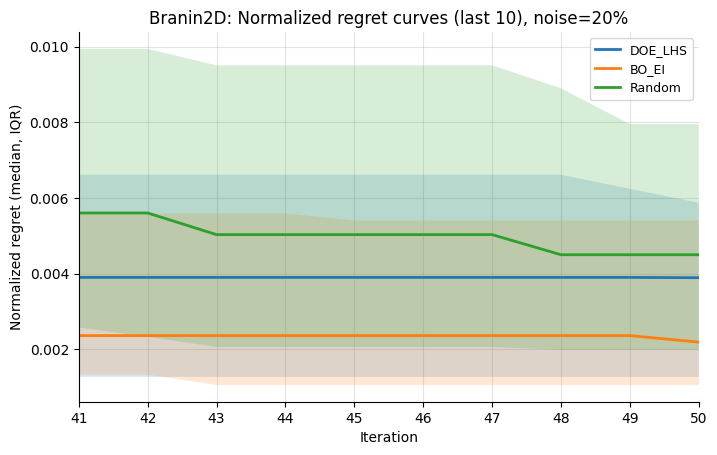

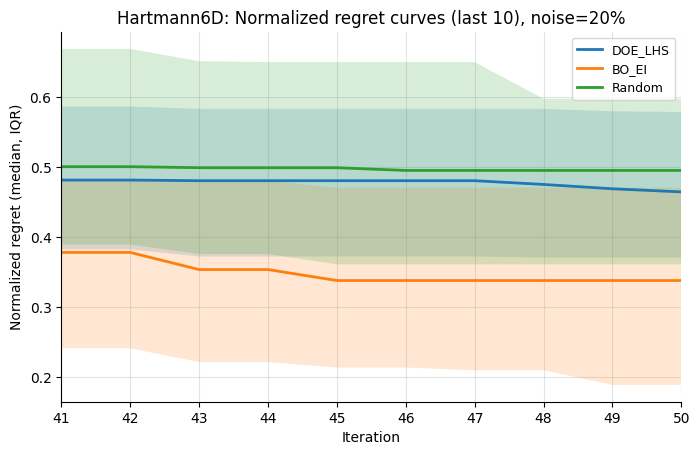

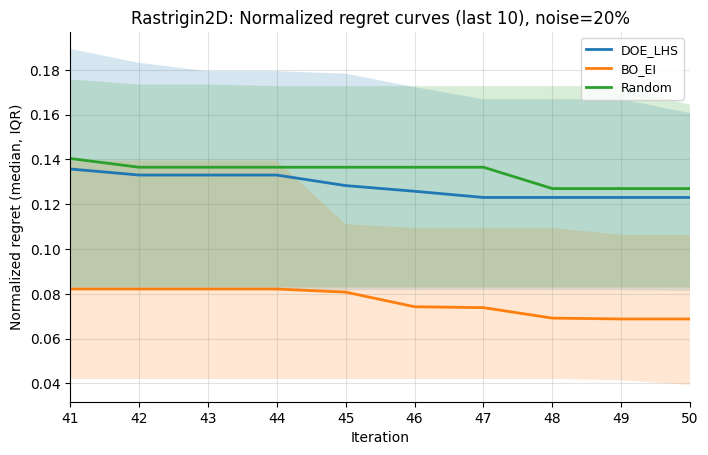

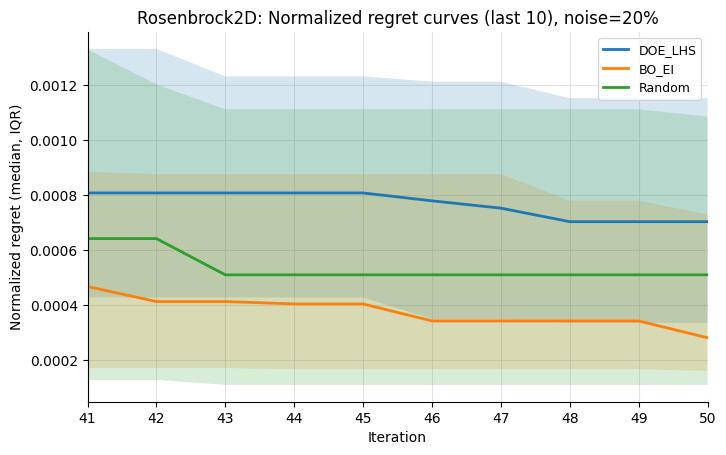

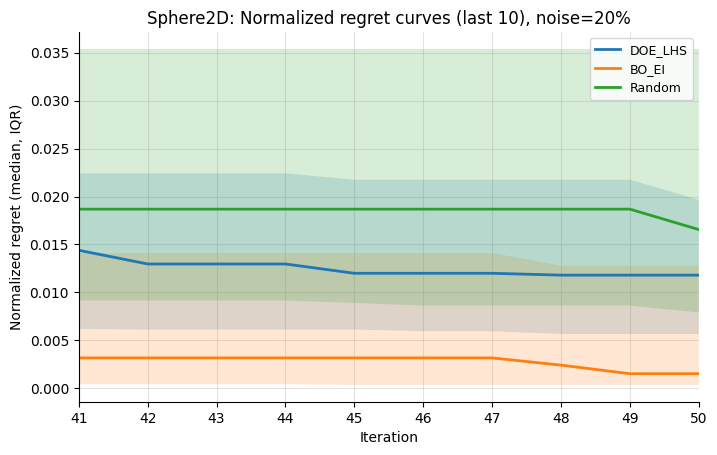

In [9]:
# ----------------------------------- LAST-10 REGRET CURVES (display only) --------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Daten laden
df_all = load_logs(outdir)
dfn    = add_normalized_regret(df_all.copy())

# volle Aggregate (für T-Bestimmung und Slicing)
agg_true_full = aggregate_regret(df_all, use_observed=False)   # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n
aggn_full     = aggregate_regret_norm(dfn)                     # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n

# --- Methoden dynamisch bestimmen (optional Reihenfolge aus main.METHODS respektieren) ---
try:
    import main
    pref_order = list(getattr(main, "METHODS", []))
except Exception:
    pref_order = []

all_methods = sorted(pd.unique(pd.concat([agg_true_full["method"], aggn_full["method"]], ignore_index=True)))
if pref_order:
    order_idx = {m: i for i, m in enumerate(pref_order)}
    methods = sorted(all_methods, key=lambda m: order_idx.get(m, len(pref_order)))
else:
    methods = all_methods

print("Plotting methods:", methods)

def _last_k_by_method(agg: pd.DataFrame, k: int) -> pd.DataFrame:
    """Nimmt je (problem, budget?, noise, method) die letzten k Iterationen (nach iter sortiert)."""
    cols = agg.columns.tolist()
    has_budget = "budget" in agg.columns
    pieces = []
    for p in sorted(agg["problem"].unique()):
        ap = agg[agg["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    iters = sorted(sm["iter"].unique())
                    take = iters[-min(k, len(iters)):]
                    pieces.append(sm[sm["iter"].isin(take)])
    return pd.concat(pieces, ignore_index=True)[cols] if pieces else agg.iloc[0:0]

agg_true_l10 = _last_k_by_method(agg_true_full, k=10)
aggn_l10     = _last_k_by_method(aggn_full,     k=10)

def _Tinfo_from_full(agg_full: pd.DataFrame):
    """Ermittelt T_end und x-Offset je (problem, noise[, budget])."""
    info = {}
    has_budget = "budget" in agg_full.columns
    for p in agg_full["problem"].unique():
        ap = agg_full[agg_full["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                it_min = int(sub["iter"].min())
                it_max = int(sub["iter"].max())
                x_off  = 1 if it_min == 0 else 0   # 0-based iter → +1
                T_end  = it_max + x_off            # z.B. 49+1 = 50
                info[(p, n, b)] = (T_end, x_off)
    return info

Tinfo_true = _Tinfo_from_full(agg_true_full)
Tinfo_norm = _Tinfo_from_full(aggn_full)

def _plot_windowed_curves(slice_lastk: pd.DataFrame, Tinfo_full: dict,
                          title_prefix: str, ylabel: str, k:int=10):
    """Zeigt die letzten k Punkte, x-Achse endet exakt bei T=max und beginnt bei T-k+1."""
    if slice_lastk.empty:
        print("[warn] No data to plot.")
        return
    has_budget = "budget" in slice_lastk.columns
    for p in sorted(slice_lastk["problem"].unique()):
        ap = slice_lastk[slice_lastk["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                key = (p, n, b)
                if key not in Tinfo_full:
                    continue
                T_end, x_off = Tinfo_full[key]
                xmin, xmax = max(1, T_end - (k - 1)), T_end

                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                # Methoden für dieses Subset dynamisch (in gewünschter Reihenfolge)
                present = [m for m in methods if m in set(sub["method"])]

                fig, ax = plt.subplots(figsize=(8, 4.8))
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    x  = sm["iter"].to_numpy(dtype=float) + x_off
                    y  = sm["median"].to_numpy(dtype=float)
                    q1 = sm["q25"].to_numpy(dtype=float)
                    q3 = sm["q75"].to_numpy(dtype=float)
                    ax.plot(x, y, label=m, linewidth=2.0)
                    ax.fill_between(x, q1, q3, alpha=0.18)

                seeds_txt = ""
                if "n" in sub.columns and sub["n"].notna().any():
                    try: seeds_txt = f", N={int(sub['n'].max())} seeds"
                    except: pass

                title = f"{p}: {title_prefix} (last {k}{seeds_txt}), noise={int(round(100*float(n)))}%"
                if b is not None:
                    title += f", T={int(b)}"

                ax.set_title(title)
                ax.set_xlabel("Iteration")
                ax.set_ylabel(ylabel)
                ax.set_xlim(xmin, xmax)                         # endet garantiert bei T=max
                xt = list(range(xmin, xmax+1))
                if len(xt) > 10:
                    step = int(np.ceil(len(xt)/10))
                    xt = list(range(xmin, xmax+1, step))
                    if xt[-1] != xmax:
                        xt.append(xmax)
                ax.set_xticks(xt)
                ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
                for s in ("top","right"): ax.spines[s].set_visible(False)
                ax.legend(loc="upper right")
                plt.show()

# Anzeigen (nur display)
# _plot_windowed_curves(agg_true_l10, Tinfo_true, title_prefix="Regret curves",            ylabel="Regret (median, IQR)", k=10)
_plot_windowed_curves(aggn_l10,     Tinfo_norm, title_prefix="Normalized regret curves", ylabel="Normalized regret (median, IQR)", k=10)


In [21]:
# --------------------- SB7 INLINE BOXPLOT: BO/DOE/Random je Problem (Final normalized regret @T) ---------------------
from pathlib import Path
from typing import Optional, Sequence, List
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms as mtransforms
from IPython.display import Markdown, display
import evaluator as ev

# optionaler Style
try:
    import tb_style
    tb_style.apply()
except Exception:
    pass

def _value_col_from_metric(metric: str) -> str:
    m = metric.lower()
    if m in ("regret","true"): return "regret"
    if m in ("regret_norm","norm","normalized","normalized_regret"): return "regret_norm"
    if m in ("best_so_far","best"): return "best_so_far"
    raise ValueError("metric must be one of {'regret','regret_norm','best_so_far'}")

def _ylabel_from_metric(metric: str) -> str:
    m = metric.lower()
    if m == "regret": return "Final regret @ T"
    if m == "regret_norm": return "Final normalized regret @ T"
    if m == "best_so_far": return "Final best value @ T"
    return metric

def plot_box_methods_by_problem_inline(
    outdir: Path,
    problems: Optional[Sequence[str]] = ("Branin2D","Rosenbrock2D","Rastrigin2D","Sphere2D","Hartmann6"),
    methods: Optional[Sequence[str]] = ("BO_EI","DOE_LHS","Random"),
    display_name_map: Optional[dict] = None,  # {"BO_EI":"BO","DOE_LHS":"DOE","Random":"Random"}
    metric: str = "regret_norm",              # SB7: normalized regret
    budget: int = 50,                         # SB7: genau ein Budget
    noise_filter: Optional[float] = 0.20,     # z. B. α = 0.20
    show_all_seeds: bool = True,
    highlight_seed: Optional[int] = None,

    # --- Layout ---
    jitter: float = 0.12,
    box_width: float = 0.24,      # Breite der Boxen
    method_sep: float = 0.28,     # Abstand der Boxen innerhalb einer Problem-Gruppe
    cluster_sep: float = 1.05,    # Abstand zwischen Problem-Gruppen
    bottom_pad: float = 0.32,
    ypad: float = 0.06,
    y_min_override: Optional[float] = None,
    y_max_override: Optional[float] = None,
    decimals: int = 3,
    median_display: str = "table",   # 'table' | 'none'
    method_y: float = -0.06,
    cluster_y: float = -0.12,

    # --- Median-Optik ---
    median_text_color: str = "#ff7f0e",
    median_fontsize: int = 9,
):
    # --- Helper ---
    col = _value_col_from_metric(metric)
    ylabel = _ylabel_from_metric(metric)

    # Logs laden (vollständig sortiert, damit spätere Operationen konsistent sind)
    df = ev.load_logs(outdir).sort_values("iter")

    # Falls normalized regret noch fehlt: versuchen, ihn zu ergänzen
    if col == "regret_norm" and "regret_norm" not in df.columns:
        try:
            # viele Pipelines liefern diese Funktion bereits
            df = ev.add_normalized_regret(df.copy())
        except Exception:
            pass
    if col == "regret_norm" and "regret_norm" not in df.columns:
        raise AssertionError("Spalte 'regret_norm' fehlt. Bitte in der Pipeline add_normalized_regret() ausführen.")

    # Finalzeilen je Run bestimmen
    try:
        base = ev._final_rows_per_run(df)
    except Exception:
        keys = ["problem","method","seed","budget"]
        if "noise_pct" in df.columns:
            keys.append("noise_pct")
        base = df.groupby(keys, as_index=False).apply(lambda g: g.sort_values("iter").iloc[-1]).reset_index(drop=True)

    if base.empty:
        raise ValueError("No data after final-row filtering.")

    # noise_pct & budget robust ableiten/ergänzen
    if "noise_pct" not in base.columns:
        base = base.copy(); base["noise_pct"] = 0.0
    if "budget" not in base.columns:
        g = df.sort_values("iter").groupby(["problem","method","seed"], as_index=False)["iter"].max()
        base = base.merge(g, on=["problem","method","seed"], suffixes=("","_as_budget"))
        base["budget"] = base["iter_as_budget"].astype(int)

    # Filter: Probleme, Budget, Noise
    if problems is not None:
        problems = list(problems)
        sub = base[base["problem"].isin(problems)].copy()
    else:
        sub = base.copy()

    if noise_filter is not None:
        sub = sub[np.isfinite(sub["noise_pct"])]
        sub = sub[np.isclose(sub["noise_pct"].astype(float), float(noise_filter))]
        if sub.empty:
            raise ValueError(f"No rows at noise={noise_filter}")

    sub = sub[pd.to_numeric(sub["budget"], errors="coerce").fillna(-1).astype(int) == int(budget)].copy()
    if sub.empty:
        raise ValueError(f"No rows for budget T={budget}")

    # Methoden-Auswahl
    methods = list(methods) if methods is not None else sorted(sub["method"].unique().tolist())
    sub = sub[sub["method"].isin(methods)].copy()
    if sub.empty:
        raise ValueError("No rows after method filtering.")

    # Anzeigenamen
    if display_name_map is None:
        display_name_map = {"BO_EI":"BO_EI","DOE_LHS":"DOE_LHS","Random":"Random"}
    disp = lambda m: display_name_map.get(m, m)

    # Problem-Reihenfolge
    problems_use: List[str] = problems if problems is not None else sorted(sub["problem"].unique().tolist())
    problems_use = [p for p in problems_use if p in set(sub["problem"])]

    if not problems_use:
        raise ValueError("No requested problems found in data.")

    # Y-Limits vorbereiten (für normalized regret oft [0,1], aber robust berechnen)
    data_all = []
    for p in problems_use:
        dP = sub[sub["problem"] == p]
        for m in methods:
            vals = dP[dP["method"] == m][col].to_numpy()
            if vals.size:
                data_all.append(vals)

    if col in ("regret","regret_norm"):
        y_min = 0.0
    else:
        y_min = float(np.nanmin([np.nanmin(d) for d in data_all])) if data_all else 0.0

    ymax = (np.nanmax([np.nanmax(d) for d in data_all]) if data_all else 1.0)
    y_max = (1.0 if not np.isfinite(ymax) else ymax) * (1.0 + ypad)

    # Plot
    fig, ax = plt.subplots(figsize=(max(16, 2.6*len(problems_use)), 6.5))
    centers = (np.arange(len(problems_use), dtype=float) * cluster_sep) + 1.0
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    shown_rows = []

    for i, prob in enumerate(problems_use):
        dP = sub[sub["problem"] == prob]
        if dP.empty:
            continue
        M = len(methods)
        offs = ((np.arange(M) - (M-1)/2.0) * method_sep).astype(float)

        for j, m in enumerate(methods):
            vals = dP[dP["method"] == m][col].to_numpy()
            if not vals.size:
                continue

            x0 = centers[i] + offs[j]
            ax.boxplot(
                [vals], positions=[x0], widths=box_width, showfliers=False,
                medianprops=dict(color=median_text_color, linewidth=1.5)
            )
            if show_all_seeds:
                xs = x0 + (np.linspace(-jitter, jitter, len(vals)) if len(vals) > 1 else np.array([0.0]))
                sc = ax.scatter(xs, vals, s=20, c="0.6", zorder=3)
                if highlight_seed is not None and "seed" in dP.columns:
                    # optional: Seed hervorheben (orange Umrandung)
                    v_seeds = dP[dP["method"] == m]["seed"].to_numpy()
                    # keine spezifische Zuordnung zum Punkt ohne jitter-track, daher weggelassen
                    pass

            # Methodenlabel
            ax.text(x0, method_y, disp(m), transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

            # median numeric label (optional, standard aus)
            # med = float(np.nanmedian(vals))
            # ax.text(x0, med, f"{med:.2f}", ha="center", va="bottom",
            #         fontsize=median_fontsize, color=median_text_color, clip_on=True)

            for v in vals:
                shown_rows.append((prob, m, float(v)))

        # Problem-Label zentriert unter dem Cluster
        ax.text(centers[i], cluster_y, f"{prob}", transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

    # Achsen & Grid
    ax_ymin, ax_ymax = y_min, y_max
    if y_min_override is not None: ax_ymin = float(y_min_override)
    if y_max_override is not None: ax_ymax = float(y_max_override)
    ax.set_ylim(ax_ymin, ax_ymax)
    ax.set_autoscale_on(False)

    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
    for s in ("top","right"): ax.spines[s].set_visible(False)
    ax.set_xticks([]); ax.set_xlabel("")

    fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))

    n_seeds_total = int(sub["seed"].nunique()) if "seed" in sub.columns else int(len(sub))
    ax.set_title(f"SB7 — Methods per problem at T={int(budget)} — {ylabel.replace('Final ','').replace(' @ T',' at T')} (N={n_seeds_total}), α={noise_filter}")
    plt.show()

    # Tabelle
    if median_display == "table" and shown_rows:
        df_tab = pd.DataFrame(shown_rows, columns=["problem","method",col])
        summary = (
            df_tab.groupby(["problem","method"])[col]
            .agg(n="count", median="median",
                 q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75),
                 mean="mean", std="std", min="min", max="max")
            .reset_index()
            .sort_values(["problem","method"])
        )
        summary["method"] = summary["method"].map(lambda m: display_name_map.get(m, m))
        summary = summary[["problem","method","n","median","q25","q75","mean","std","min","max"]].round(decimals)
        display(Markdown("**Per-problem × method summary (final @ T, shown only):**"))
        display(summary)
        return summary

    return None


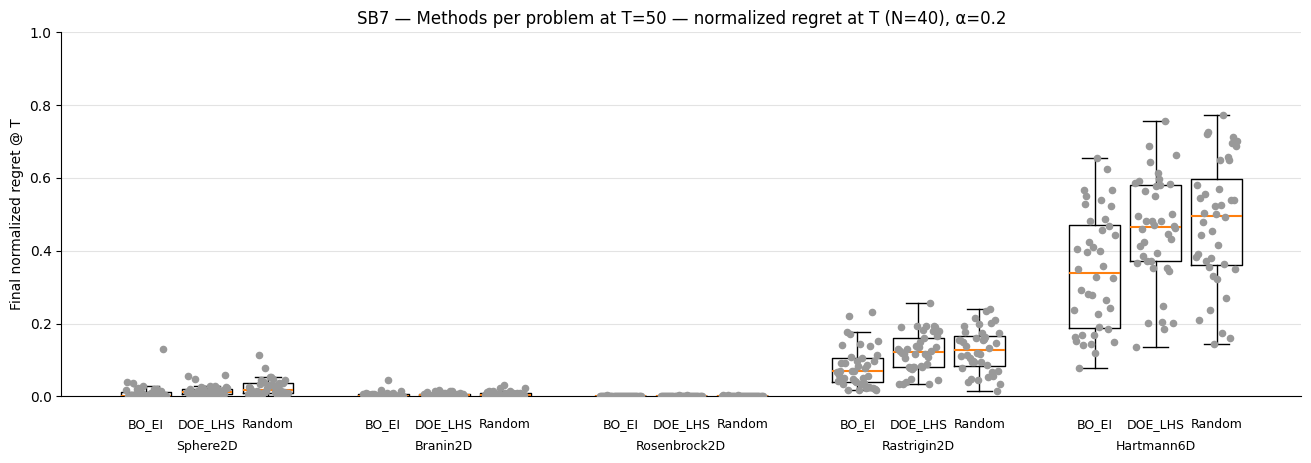

**Per-problem × method summary (final @ T, shown only):**

problem   method   n  median    q25    q75   mean    std    min  \
0       Branin2D    BO_EI  40   0.002  0.001  0.005  0.005  0.008  0.000   
1       Branin2D  DOE_LHS  40   0.004  0.001  0.006  0.005  0.004  0.000   
2       Branin2D   Random  40   0.005  0.002  0.008  0.006  0.007  0.000   
3     Hartmann6D    BO_EI  40   0.338  0.189  0.471  0.344  0.160  0.078   
4     Hartmann6D  DOE_LHS  40   0.465  0.371  0.579  0.453  0.148  0.136   
5     Hartmann6D   Random  40   0.496  0.361  0.598  0.477  0.172  0.144   
6    Rastrigin2D    BO_EI  40   0.069  0.039  0.106  0.081  0.055  0.016   
7    Rastrigin2D  DOE_LHS  40   0.123  0.081  0.161  0.121  0.054  0.034   
8    Rastrigin2D   Random  40   0.127  0.083  0.164  0.127  0.059  0.015   
9   Rosenbrock2D    BO_EI  40   0.000  0.000  0.001  0.001  0.001  0.000   
10  Rosenbrock2D  DOE_LHS  40   0.001  0.000  0.001  0.001  0.001  0.000   
11  Rosenbrock2D   Random  40   0.001  0.000  0.001  0.001  0.001  0.000   
12      Sphere2D    BO_EI  40   0.002  0.000  0.013  0.010  0.022  0.000   
13      Sphere2D  DOE_LHS  40   0.012  0.006  0.020  0.015  0.014  0.000   
14      Sphere2D   Random  40   0.017  0.008  0.035  0.025  0.023  0.000   

      max  
0   0.045  
1   0.017  
2   0.031  
3   0.654  
4   0.757  
5   0.772  
6   0.231  
7   0.257  
8   0.241  
9   0.004  
10  0.003  
11  0.004  
12  0.129  
13  0.058  
14  0.114

In [33]:
from pathlib import Path

_ = plot_box_methods_by_problem_inline(
    outdir=Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class"),
    problems=("Sphere2D", "Branin2D","Rosenbrock2D","Rastrigin2D","Hartmann6D"),  # passe an deine IDs an
    methods=("BO_EI","DOE_LHS","Random"),
    metric="regret_norm",    # normalized regret
    budget=50,               # genau ein T
    noise_filter=0.20,       # α
    # Layout-Tuning:
    box_width=0.30,
    method_sep=0.36,
    cluster_sep=1.40,
    y_min_override=0.0,
    y_max_override=1,
    ypad=0.0,           # kein Extra-Headroom
)


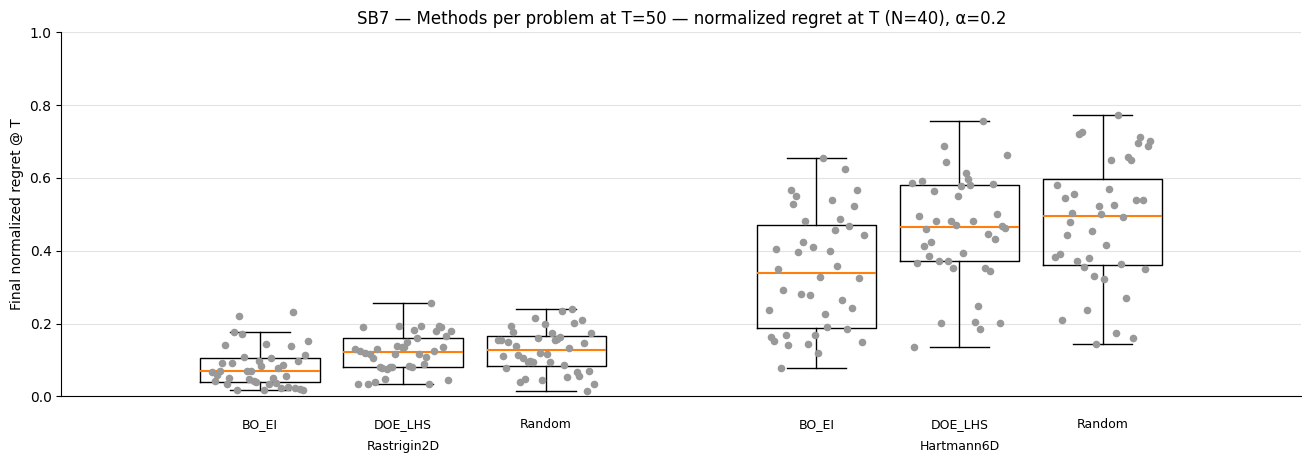

**Per-problem × method summary (final @ T, shown only):**

problem   method   n  median    q25    q75   mean    std    min    max
0   Hartmann6D    BO_EI  40   0.338  0.189  0.471  0.344  0.160  0.078  0.654
1   Hartmann6D  DOE_LHS  40   0.465  0.371  0.579  0.453  0.148  0.136  0.757
2   Hartmann6D   Random  40   0.496  0.361  0.598  0.477  0.172  0.144  0.772
3  Rastrigin2D    BO_EI  40   0.069  0.039  0.106  0.081  0.055  0.016  0.231
4  Rastrigin2D  DOE_LHS  40   0.123  0.081  0.161  0.121  0.054  0.034  0.257
5  Rastrigin2D   Random  40   0.127  0.083  0.164  0.127  0.059  0.015  0.241

In [32]:
from pathlib import Path

_ = plot_box_methods_by_problem_inline(
    outdir=Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class"),
    problems=("Rastrigin2D","Hartmann6D"),  # passe an deine IDs an
    methods=("BO_EI","DOE_LHS","Random"),
    metric="regret_norm",    # normalized regret
    budget=50,               # genau ein T
    noise_filter=0.20,       # α
    # Layout-Tuning:
    box_width=0.30,
    method_sep=0.36,
    cluster_sep=1.40,
    y_min_override=0.0,
    y_max_override=1,
    ypad=0.0,           # kein Extra-Headroom
)


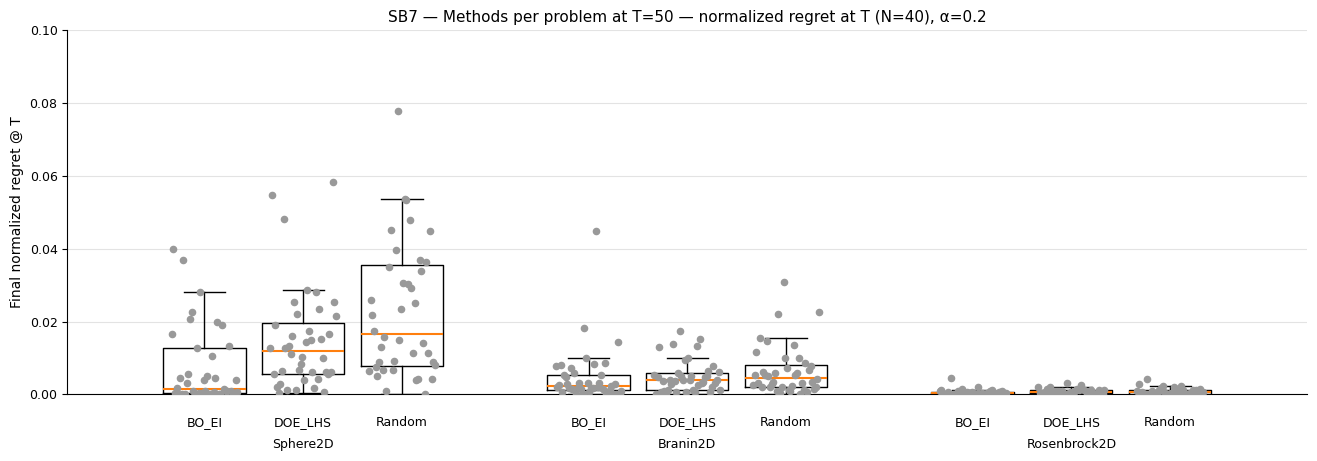

**Per-problem × method summary (final @ T, shown only):**

problem   method   n  median    q25    q75   mean    std  min    max
0      Branin2D    BO_EI  40   0.002  0.001  0.005  0.005  0.008  0.0  0.045
1      Branin2D  DOE_LHS  40   0.004  0.001  0.006  0.005  0.004  0.0  0.017
2      Branin2D   Random  40   0.005  0.002  0.008  0.006  0.007  0.0  0.031
3  Rosenbrock2D    BO_EI  40   0.000  0.000  0.001  0.001  0.001  0.0  0.004
4  Rosenbrock2D  DOE_LHS  40   0.001  0.000  0.001  0.001  0.001  0.0  0.003
5  Rosenbrock2D   Random  40   0.001  0.000  0.001  0.001  0.001  0.0  0.004
6      Sphere2D    BO_EI  40   0.002  0.000  0.013  0.010  0.022  0.0  0.129
7      Sphere2D  DOE_LHS  40   0.012  0.006  0.020  0.015  0.014  0.0  0.058
8      Sphere2D   Random  40   0.017  0.008  0.035  0.025  0.023  0.0  0.114

In [43]:
from pathlib import Path

_ = plot_box_methods_by_problem_inline(
    outdir=Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class"),
    problems=("Sphere2D", "Branin2D","Rosenbrock2D"),  # passe an deine IDs an
    methods=("BO_EI","DOE_LHS","Random"),
    metric="regret_norm",    # normalized regret
    budget=50,               # genau ein T
    noise_filter=0.20,       # α
    # Layout-Tuning:
    box_width=0.30,
    method_sep=0.36,
    cluster_sep=1.40,
    y_min_override=0.0,
    y_max_override=0.1,
    ypad=0.0,           # kein Extra-Headroom
)


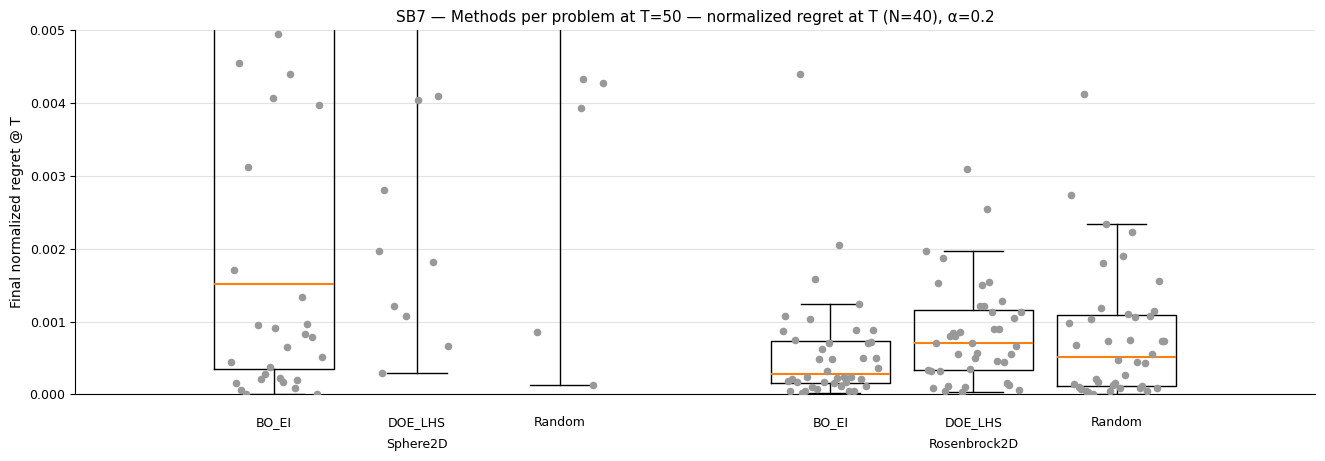

**Per-problem × method summary (final @ T, shown only):**

problem   method   n  median    q25    q75   mean    std  min    max
0  Rosenbrock2D    BO_EI  40   0.000  0.000  0.001  0.001  0.001  0.0  0.004
1  Rosenbrock2D  DOE_LHS  40   0.001  0.000  0.001  0.001  0.001  0.0  0.003
2  Rosenbrock2D   Random  40   0.001  0.000  0.001  0.001  0.001  0.0  0.004
3      Sphere2D    BO_EI  40   0.002  0.000  0.013  0.010  0.022  0.0  0.129
4      Sphere2D  DOE_LHS  40   0.012  0.006  0.020  0.015  0.014  0.0  0.058
5      Sphere2D   Random  40   0.017  0.008  0.035  0.025  0.023  0.0  0.114

In [41]:
from pathlib import Path

_ = plot_box_methods_by_problem_inline(
    outdir=Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class"),
    problems=("Sphere2D", "Rosenbrock2D"),  # passe an deine IDs an
    methods=("BO_EI","DOE_LHS","Random"),
    metric="regret_norm",    # normalized regret
    budget=50,               # genau ein T
    noise_filter=0.20,       # α
    # Layout-Tuning:
    box_width=0.30,
    method_sep=0.36,
    cluster_sep=1.40,
    y_min_override=0.0,
    y_max_override=0.005,
    ypad=0.0,           # kein Extra-Headroom
)


Text(0.5, 0.995, 'SB7 — Methods per problem at T=50 — normalized regret at T (N=40), α=0.20')

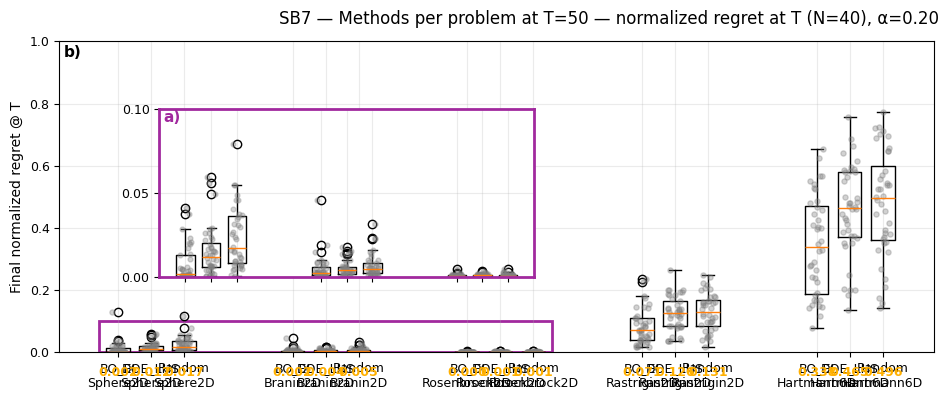

In [44]:
# ============================================
# SB7: Normalized regret @ T — Gesamtboxplot (0–1) + Zoom-Inset (0–0.1)
# - Hauptplot: alle 5 Probleme auf gemeinsamer Skala [0,1]
# - Inset: Sphere/Branin/Rosenbrock auf [0,0.1]
# - Farbig gerahmtes "Fenster" im Hauptplot deckungsgleich mit Inset
# - Medianwerte in Gelb zwischen Boxen und X-Labels
# Requirements: pandas, numpy, matplotlib
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ---------- Config ----------
FOCUS_NOISE = 0.20
FOCUS_T = 50
PROBLEMS_ORDER = ["Sphere2D","Branin2D","Rosenbrock2D","Rastrigin2D","Hartmann6D"]
METHOD_ORDER   = ["BO_EI","DOE_LHS","Random"]
ZOOM_PROBLEMS  = ["Sphere2D","Branin2D","Rosenbrock2D"]  # im Inset
HIGHLIGHT_COLOR = (0.63, 0.16, 0.62, 1.0)  # z.B. Violett, passend zu deinem Rahmen
SHOW_JITTER = True
JITTER_ALPHA = 0.35

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# ---------- Inputs ----------
# Erwartet df in globals() ODER CSV_PATH angeben
CSV_PATH = None  # r"/path/to/all_runs.csv"
if CSV_PATH:
    df = pd.read_csv(CSV_PATH)
else:
    assert 'df' in globals(), "Provide CSV_PATH or a DataFrame named df in the globals()"

# Slice SB7
df7 = df.copy()
if "noise_pct" in df7.columns:
    df7 = df7[df7["noise_pct"] == FOCUS_NOISE].copy()
if "budget" in df7.columns:
    df7 = df7[df7["budget"] == FOCUS_T].copy()

req = {"problem","method","seed","iter","regret","y","budget"}
missing = req - set(df7.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Final row per (problem,method,seed) @ T
idx = df7.groupby(["problem","method","seed","budget"])["iter"].idxmax()
finals = df7.loc[idx].copy()

# Normalisierung: S = q95 - f*
KNOWN_FSTAR = {
    "Branin2D": 0.39788735772973816,
    "Rosenbrock2D": 0.0,
    "Sphere2D": 0.0,
    "Rastrigin2D": 0.0,
    "Hartmann6D": -3.322368011415515,
}
problems_present = [p for p in PROBLEMS_ORDER if p in finals["problem"].unique()]

fstar_map = {p: KNOWN_FSTAR.get(p, float(finals.loc[finals["problem"]==p, "y"].min()))
             for p in problems_present}

S_map = {}
for p in problems_present:
    y_vals = df7.loc[df7["problem"]==p, "y"].values
    q95 = float(np.percentile(y_vals, 95))
    S_map[p] = max(q95 - fstar_map[p], 1e-12)

finals["regret_norm_T"] = finals.apply(
    lambda r: np.clip(r["regret"]/S_map[r["problem"]], 0.0, 1.0), axis=1
)

# ---------- Daten für Boxplots vorbereiten ----------
# Positionen: je Problem 3 Methoden nebeneinander, mit Lücke zwischen Problemen
group_gap = 0.8
intra_gap = 0.35
positions = []
labels = []
data = []
medians = []

x = 0.0
x_positions_per_problem = {}
for p in problems_present:
    xs = []
    for m in METHOD_ORDER:
        sub = finals[(finals["problem"]==p) & (finals["method"]==m)]
        if sub.empty: 
            continue
        positions.append(x)
        labels.append(f"{m}\n{p}")
        vals = sub["regret_norm_T"].to_numpy()
        data.append(vals)
        medians.append(float(np.median(vals)))
        xs.append(x)
        x += intra_gap
    x_positions_per_problem[p] = xs
    x += group_gap  # größere Lücke zum nächsten Problem

# ---------- Plot erstellen ----------
fig = plt.figure(figsize=(12.5, 4.2))
ax_main = fig.add_axes([0.06, 0.18, 0.70, 0.74])  # [left, bottom, width, height]
ax_inset = fig.add_axes([0.14, 0.36, 0.30, 0.40]) # Inset oben links (anpassen nach Geschmack)

# Hauptboxen (0–1)
bp = ax_main.boxplot(
    data, positions=positions, widths=0.25, patch_artist=False, manage_ticks=False, whis=1.5
)
ax_main.set_ylim(0.0, 1.0)
ax_main.set_ylabel("Final normalized regret @ T")
ax_main.grid(True, axis='y', alpha=0.25)
ax_main.set_xticks(positions)
ax_main.set_xticklabels(labels, rotation=0)

# Optionale Jitter-Punkte im Hauptplot
if SHOW_JITTER:
    rng = np.random.default_rng(42)
    for pos, vals in zip(positions, data):
        jitter = (rng.random(len(vals)) - 0.5) * 0.16
        ax_main.scatter(pos + jitter, vals, s=14, color="gray", alpha=JITTER_ALPHA, zorder=2)

# Medianlabels in Gelb (zwischen Box und Ticklabel, also leicht unter 0)
for pos, med in zip(positions, medians):
    ax_main.text(pos, -0.045, f"{med:.3f}", ha="center", va="top",
                 color="#ffb000", fontsize=9, fontweight="bold",
                 transform=ax_main.transData, clip_on=False)

# ---------- Inset: nur die "kleinen" Probleme (0–0.1) ----------
zoom_positions = []
zoom_data = []
for p in ZOOM_PROBLEMS:
    if p not in x_positions_per_problem: 
        continue
    xs = x_positions_per_problem[p]
    for m, pos in zip(METHOD_ORDER, xs):
        # Finde die passende Datenserie
        idx_pos = positions.index(pos)
        zoom_positions.append(pos)
        zoom_data.append(data[idx_pos])

bp2 = ax_inset.boxplot(
    zoom_data, positions=zoom_positions, widths=0.25, patch_artist=False, manage_ticks=False, whis=1.5
)
ax_inset.set_ylim(0.0, 0.10)
ax_inset.set_yticks([0.0, 0.05, 0.10])
ax_inset.grid(True, axis='y', alpha=0.25)
ax_inset.set_xticks(zoom_positions)
ax_inset.set_xticklabels([""]*len(zoom_positions))  # unten bleiben die Labels im Hauptplot

# Inset-Jitter
if SHOW_JITTER:
    rng2 = np.random.default_rng(123)
    for pos, vals in zip(zoom_positions, zoom_data):
        jitter = (rng2.random(len(vals)) - 0.5) * 0.16
        ax_inset.scatter(pos + jitter, vals, s=12, color="gray", alpha=JITTER_ALPHA, zorder=2)

# ---------- Fenster-Rahmen im Hauptplot (gleiche Farbe wie Inset-Rahmen) ----------
# Rechteck deckt den x-Bereich der drei kleinen Probleme und y=[0,0.1]
x_min = min(zoom_positions) - 0.20
x_max = max(zoom_positions) + 0.20
rect = Rectangle((x_min, 0.0), width=(x_max - x_min), height=0.10,
                 fill=False, edgecolor=HIGHLIGHT_COLOR, linewidth=2.0)
ax_main.add_patch(rect)
# Inset-Rahmen farbgleich
for spine in ax_inset.spines.values():
    spine.set_edgecolor(HIGHLIGHT_COLOR)
    spine.set_linewidth(2.0)

# ---------- Panels a) / b) ----------
ax_main.text(0.005, 0.99, "b)", transform=ax_main.transAxes,
             ha="left", va="top", fontsize=11, fontweight="bold")
ax_inset.text(0.01, 0.99, "a)", transform=ax_inset.transAxes,
              ha="left", va="top", fontsize=11, fontweight="bold", color=HIGHLIGHT_COLOR)

# ---------- Titel ----------
fig.suptitle("SB7 — Methods per problem at T=50 — normalized regret at T (N=40), α=0.20", y=0.995)

# Hinweis: wenn die gelben Zahlen abgeschnitten sind, unteren Rand erhöhen:
# fig.subplots_adjust(bottom=0.22)

# Save:
# fig.savefig("SB7_norm_boxplots_with_inset.png", dpi=300, bbox_inches="tight")


C:\Users\marti\AppData\Local\Temp\ipykernel_51752\3492039768.py:94: FutureWarning: The provided callable <function median at 0x0000014367D2C9D0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  per_seed_nauc.groupby(["problem","method"], as_index=False)


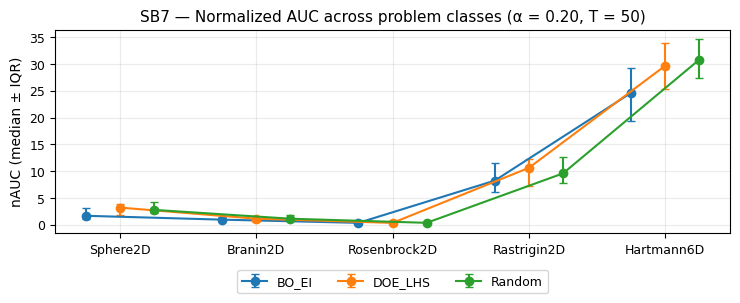

In [36]:
# ============================================
# SB7: Normalized AUC (nAUC) across problem classes (median ± IQR)
# Requirements: pandas, numpy, matplotlib (no seaborn)
# Style aligned with your SB6 code
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Config ----------
CSV_PATH = r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class\all_runs.csv"  # e.g. r"/path/to/all_runs.csv" or keep None if df provided
FOCUS_NOISE = 0.20          # SB7 default
FOCUS_T = 50                # SB7 default
# Preferred display order for problems and methods
PROBLEMS_ORDER = ["Sphere2D","Branin2D","Rosenbrock2D","Rastrigin2D","Hartmann6D"]
METHOD_ORDER = ["BO_EI", "DOE_LHS", "Random"]

# ---------- Optional: use thesis font sizes ----------
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# ---------- Load ----------
if CSV_PATH is not None:
    df = pd.read_csv(CSV_PATH)
else:
    assert 'df' in globals(), "Provide CSV_PATH or a DataFrame named df in the globals()"

# ---------- Slice to SB7 (true regret, α=0.20, T=50) ----------
df_sb7 = df.copy()
if "noise_pct" in df_sb7.columns:
    df_sb7 = df_sb7[df_sb7["noise_pct"] == FOCUS_NOISE].copy()
if "budget" in df_sb7.columns:
    df_sb7 = df_sb7[df_sb7["budget"] == FOCUS_T].copy()

required_cols = {"problem","method","seed","iter","regret","y"}
missing = required_cols - set(df_sb7.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ---------- nAUC helpers ----------
def _detect_method_order(df_in, default_order):
    present = df_in["method"].unique().tolist()
    return [m for m in default_order if m in present] + [m for m in present if m not in default_order]

def trapezoid_auc(arr: np.ndarray) -> float:
    if arr.size < 2:
        return 0.0
    return float(np.sum((arr[:-1] + arr[1:]) * 0.5))

# known f* with fallback to empirical min(y)
KNOWN_FSTAR = {
    "Branin2D": 0.39788735772973816,
    "Rosenbrock2D": 0.0,
    "Sphere2D": 0.0,
    "Rastrigin2D": 0.0,
    "Hartmann6D": -3.322368011415515,
}

problems_present = df_sb7["problem"].unique().tolist()
fstar_map = {
    p: KNOWN_FSTAR.get(p, float(df_sb7.loc[df_sb7["problem"]==p, "y"].min()))
    for p in problems_present
}

# per-problem scale S = q95 - f*
S_map = {}
for p in problems_present:
    y_vals = df_sb7.loc[df_sb7["problem"]==p, "y"].values
    q95 = float(np.percentile(y_vals, 95))
    S_map[p] = max(q95 - fstar_map[p], 1e-12)

# per-seed nAUC with clipping to [0,1]
rows = []
for (p,m,s), g in df_sb7.sort_values("iter").groupby(["problem","method","seed"]):
    S = S_map[p]
    rnorm = np.clip(g["regret"].to_numpy() / S, 0.0, 1.0)
    nauc = trapezoid_auc(rnorm)
    rows.append({"problem": p, "method": m, "seed": s, "nAUC": nauc})

per_seed_nauc = pd.DataFrame(rows)

# aggregate (median ± IQR)
def q25(x): return float(np.percentile(x, 25))
def q75(x): return float(np.percentile(x, 75))

nauc_summary = (
    per_seed_nauc.groupby(["problem","method"], as_index=False)
                 .agg(nAUC_q1=("nAUC", q25),
                      nAUC_median=("nAUC", np.median),
                      nAUC_q3=("nAUC", q75))
)

# ---------- Plot: single-axis nAUC mini-figure (median ± IQR) ----------
def plot_nauc_minifig(summary_df, problems_order=None, method_order=None):
    if problems_order is None:
        problems_order = sorted(summary_df["problem"].unique().tolist())
    else:
        problems_order = [p for p in problems_order if p in summary_df["problem"].unique()]
    if method_order is None:
        method_order = _detect_method_order(summary_df, METHOD_ORDER)

    x_base = np.arange(len(problems_order), dtype=float)
    m = len(method_order)
    offsets = np.linspace(-0.25, 0.25, m) if m > 1 else np.array([0.0])
    offset_map = {meth: off for meth, off in zip(method_order, offsets)}

    fig, ax = plt.subplots(figsize=(7.5, 3.2))
    for meth in method_order:
        sub = (summary_df[summary_df["method"] == meth]
               .set_index("problem")
               .reindex(problems_order))
        y = sub["nAUC_median"].to_numpy()
        q1 = sub["nAUC_q1"].to_numpy()
        q3 = sub["nAUC_q3"].to_numpy()
        x = x_base + offset_map[meth]
        yerr = np.vstack([y - q1, q3 - y])

        # Errorbar (median ± IQR) with point markers; no explicit colors/styles
        ax.errorbar(x, y, yerr=yerr, marker='o', linewidth=1.5, capsize=3, label=meth)

    ax.set_xticks(x_base)
    ax.set_xticklabels(problems_order)
    ax.set_ylabel("nAUC (median ± IQR)")
    ax.set_title("SB7 — Normalized AUC across problem classes (α = {:.2f}, T = {})".format(FOCUS_NOISE, FOCUS_T))
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=len(method_order), loc="upper center", bbox_to_anchor=(0.5, -0.15))

    fig.tight_layout()
    return fig, ax

# ---------- Build and plot ----------
nauc_summary = nauc_summary.sort_values(["problem","method"])
fig, ax = plot_nauc_minifig(nauc_summary, problems_order=PROBLEMS_ORDER, method_order=METHOD_ORDER)

# If you want to save:
# fig.savefig("SB7_nAUC_mini_figure.png", dpi=300, bbox_inches="tight")
# ============================================


C:\Users\marti\AppData\Local\Temp\ipykernel_51752\305100425.py:77: FutureWarning: The provided callable <function median at 0x0000014367D2C9D0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  finals.groupby(["problem","method"], as_index=False)


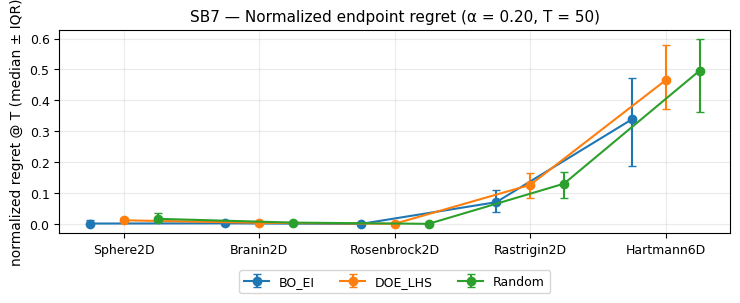

In [42]:
# ============================================
# SB7: Normalized endpoint regret @ T (median ± IQR) across problem classes
# Requirements: pandas, numpy, matplotlib (no seaborn)
# Style aligned with your SB6/nAUC mini-figure
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Config ----------
CSV_PATH = None  # e.g. r"/path/to/all_runs.csv" or keep None if df provided
FOCUS_NOISE = 0.20
FOCUS_T = 50
PROBLEMS_ORDER = ["Sphere2D","Branin2D","Rosenbrock2D","Rastrigin2D","Hartmann6D"]
METHOD_ORDER = ["BO_EI","DOE_LHS","Random"]
SHOW_IQR = True  # set to False for median-only markers

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# ---------- Load ----------
if CSV_PATH is not None:
    df = pd.read_csv(CSV_PATH)
else:
    assert 'df' in globals(), "Provide CSV_PATH or a DataFrame named df in the globals()"

# ---------- Slice to SB7 (true regret, α=0.20, T=50) ----------
df_sb7 = df.copy()
if "noise_pct" in df_sb7.columns:
    df_sb7 = df_sb7[df_sb7["noise_pct"] == FOCUS_NOISE].copy()
if "budget" in df_sb7.columns:
    df_sb7 = df_sb7[df_sb7["budget"] == FOCUS_T].copy()

req = {"problem","method","seed","iter","regret","y","budget"}
missing = req - set(df_sb7.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ---------- Finals @ T ----------
idx = df_sb7.groupby(["problem","method","seed","budget"])["iter"].idxmax()
finals = df_sb7.loc[idx].copy()

# ---------- Normalization scale S = q95 - f* ----------
KNOWN_FSTAR = {
    "Branin2D": 0.39788735772973816,
    "Rosenbrock2D": 0.0,
    "Sphere2D": 0.0,
    "Rastrigin2D": 0.0,
    "Hartmann6D": -3.322368011415515,
}
problems_present = finals["problem"].unique().tolist()
fstar_map = {p: KNOWN_FSTAR.get(p, float(df_sb7.loc[df_sb7["problem"]==p,"y"].min())) for p in problems_present}

S_map = {}
for p in problems_present:
    y_vals = df_sb7.loc[df_sb7["problem"]==p, "y"].values
    q95 = float(np.percentile(y_vals, 95))
    S_map[p] = max(q95 - fstar_map[p], 1e-12)

# ---------- Compute regret_norm(T) per seed ----------
finals["regret_norm_T"] = finals.apply(
    lambda r: max(min(r["regret"] / S_map[r["problem"]], 1.0), 0.0), axis=1
)

# ---------- Aggregate median ± IQR per (problem, method) ----------
def q25(x): return float(np.percentile(x,25))
def q75(x): return float(np.percentile(x,75))

ep_norm_summary = (
    finals.groupby(["problem","method"], as_index=False)
          .agg(regret_norm_q1=("regret_norm_T", q25),
               regret_norm_median=("regret_norm_T", np.median),
               regret_norm_q3=("regret_norm_T", q75))
          .sort_values(["problem","method"])
)

# ---------- Mini-figure (median ± IQR), single axis ----------
def _detect_method_order(df_in, default_order):
    present = df_in["method"].unique().tolist()
    return [m for m in default_order if m in present] + [m for m in present if m not in default_order]

def plot_norm_ep_minifig(summary_df, problems_order=None, method_order=None, show_iqr=True):
    if problems_order is None:
        problems_order = sorted(summary_df["problem"].unique().tolist())
    else:
        problems_order = [p for p in problems_order if p in summary_df["problem"].unique()]
    if method_order is None:
        method_order = _detect_method_order(summary_df, METHOD_ORDER)

    x_base = np.arange(len(problems_order), dtype=float)
    m = len(method_order)
    offsets = np.linspace(-0.25, 0.25, m) if m > 1 else np.array([0.0])
    offset_map = {meth: off for meth, off in zip(method_order, offsets)}

    fig, ax = plt.subplots(figsize=(7.5, 3.2))
    for meth in method_order:
        sub = (summary_df[summary_df["method"] == meth]
               .set_index("problem")
               .reindex(problems_order))
        y = sub["regret_norm_median"].to_numpy()
        q1 = sub["regret_norm_q1"].to_numpy()
        q3 = sub["regret_norm_q3"].to_numpy()
        x = x_base + offset_map[meth]

        if show_iqr:
            yerr = np.vstack([y - q1, q3 - y])
            ax.errorbar(x, y, yerr=yerr, marker='o', linewidth=1.5, capsize=3, label=meth)
        else:
            ax.plot(x, y, marker='o', linewidth=1.5, label=meth)

    ax.set_xticks(x_base)
    ax.set_xticklabels(problems_order)
    ax.set_ylabel("normalized regret @ T (median ± IQR)")
    ax.set_title("SB7 — Normalized endpoint regret (α = {:.2f}, T = {})".format(FOCUS_NOISE, FOCUS_T))
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=len(method_order), loc="upper center", bbox_to_anchor=(0.5, -0.15))
    fig.tight_layout()
    return fig, ax

fig_ep, ax_ep = plot_norm_ep_minifig(
    ep_norm_summary, problems_order=PROBLEMS_ORDER, method_order=METHOD_ORDER, show_iqr=SHOW_IQR
)

# If you want to save:
# fig_ep.savefig("SB7_norm_endpoint_mini_figure.png", dpi=300, bbox_inches="tight")
# ============================================


In [ ]:
# === SB7: Pro Problem × Methode @T=50 je EIN Kombi-Bild (2D|3D) mit Footer (seed-Auswahl via Overrides + Heuristik)
from pathlib import Path
from IPython.display import HTML, display, Markdown
from PIL import Image, ImageDraw, ImageFont
from contextlib import contextmanager
import base64, mimetypes, re, math
import numpy as np
import pandas as pd
from typing import Optional
import importlib

# ---------- Pfade und Parameter ----------
OUTDIR = Path(r"C:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\results\20251102_023234_SB7_Problem_class")

# SB7: viele Probleme, ein Budget
PROBLEMS   = ["Branin2D", "Rosenbrock2D", "Rastrigin2D", "Sphere2D", "Hartmann6"]
METHODS    = ["BO_EI", "DOE_LHS", "Random"]
BUDGET     = 50             # SB7: genau ein T
ALPHA      = 0.20           # Rauschlevel
METRIC     = "regret_norm"  # SB7: normalized regret
LABEL_MAP  = {"regret":"regret", "regret_obs":"observed regret", "regret_norm":"normalized regret"}
LABEL      = LABEL_MAP[METRIC]

# Anzeige / Ausgabe
SAVE_COMBOS   = True                                 # True → PNGs unter OUTDIR/samples_pairs speichern
PAIRS_DIR     = OUTDIR / "samples_pairs"
CARDS_WIDTH   = 1200                                 # Anzeige-Breite im Notebook
COMBO_H       = 900                                  # Höhe je Teilbild (px)
GAP           = 18                                   # Spaltbreite
FOOT_H        = 52                                   # Footer-Höhe
BG            = (255, 255, 255)
FOOT_BG       = (250, 250, 250)
TEXT_COLOR    = (30, 30, 30)

# ---------- Seeds fest vorgeben (inkl. Alternativen) ----------
# Hinweis: int oder Liste[int] erlaubt. Bei Liste kann optional alles gerendert werden.
SEED_OVERRIDES = {
    "Branin2D": {
        "BO_EI":   [15, 26, 27],  # 15 = Hauptbeispiel; 26/27 = Alternativen
        "DOE_LHS": [18],
        "Random":  [26],
    },
    "Rosenbrock2D": {
        "BO_EI":   [13, 22],      # 13 = Hauptbeispiel; 22 = Alternative
        "DOE_LHS": [29],
        "Random":  [37],
    },
    # Für Rastrigin2D, Sphere2D, Hartmann6 bleibt die automatische Heuristik aktiv
}

# Wenn True: ALLE aufgeführten Overrides rendern (z. B. Branin BO_EI 15, 26, 27).
# Wenn False: Nur den ersten Eintrag pro Methode verwenden (z. B. nur 15).
RENDER_ALL_OVERRIDES = True


# ---------- Hilfsfunktionen ----------
def _text_wh(draw, text: str, font):
    if hasattr(draw, "textbbox"):
        l, t, r, b = draw.textbbox((0, 0), text, font=font)
        return (r - l, b - t)
    try:
        l, t, r, b = font.getbbox(text)
        return (r - l, b - t)
    except Exception:
        pass
    try:
        return font.getsize(text)
    except Exception:
        return (len(text) * 8, 16)

def _load_resize_h(path: Path, target_h: int) -> Image.Image:
    im = Image.open(path).convert("RGB")
    w, h = im.size
    if h != target_h:
        w_new = int(round(w * (target_h / h)))
        im = im.resize((w_new, target_h), Image.LANCZOS)
    return im

def _iter_from_2d_name(p2d: Path) -> int:
    m = re.match(r"^samples2d_it(\d+)_Tfinal\.png$", p2d.name)
    return int(m.group(1)) if m else -1

@contextmanager
def _enable_real_saving_no_tight():
    """Sicheres Speichern der von viz_samples erzeugten Figuren ohne bbox='tight'."""
    import matplotlib.figure as mfigure
    backup = mfigure.Figure.savefig
    def _save(self, fname, *args, **kwargs):
        kwargs.pop("bbox_inches", None)
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        if not hasattr(self, "canvas") or self.canvas is None or self.canvas.__class__.__name__ != "FigureCanvasAgg":
            self.set_canvas(FigureCanvasAgg(self))
        self.canvas.print_figure(fname, **kwargs)
    mfigure.Figure.savefig = _save
    try:
        yield
    finally:
        mfigure.Figure.savefig = backup

def _count_improvements(series: pd.Series) -> int:
    """Zählt, wie oft das METRIC cumulative-min sinkt. Eignet sich als 'viele kleine Schritte' Indikator."""
    x = series.to_numpy(dtype=float)
    if x.size == 0:
        return 0
    cmin = np.minimum.accumulate(x)
    # Ein 'Verbesserungsevent' wenn cmin sich reduziert
    return int(np.sum(np.diff(cmin) < 0.0))

def _pick_valley_seed(df_all: pd.DataFrame, problem: str, method: str, budget: int, alpha: float, col_metric: str) -> Optional[int]:
    """Heuristik: wähle Seed mit vielen Verbesserungen und kleinem finalem METRIC."""
    sub = df_all[
        (df_all["problem"] == problem) &
        (df_all["method"]  == method)
    ].copy()
    if "noise_pct" in sub.columns:
        sub = sub[np.isfinite(sub["noise_pct"])]
        sub = sub[np.isclose(sub["noise_pct"].astype(float), float(alpha))]
    if sub.empty:
        return None

    # Pro Seed nur Runs mit passendem Budget erwägen
    if "iter" not in sub.columns:
        return None
    # Budget je Seed bestimmen
    gT = sub.groupby("seed")["iter"].max().astype(int).reset_index(name="Tmax")
    gT["T"] = gT["Tmax"] + (gT["Tmax"] == 0).astype(int)  # 0-basierte Iter → T = max_iter + 1
    seeds_ok = gT.loc[gT["T"] == int(budget), "seed"].astype(int).tolist()
    if not seeds_ok:
        return None

    best_seed = None
    best_key  = None  # sort key: (-improv, final_metric, seed)

    for seed in seeds_ok:
        s = sub[sub["seed"] == int(seed)].sort_values("iter")
        if col_metric not in s.columns or s[col_metric].isna().all():
            continue
        m = s[col_metric].astype(float)
        # finaler Wert
        final_val = float(m.iloc[-1])
        # Verbesserungs-Events zählen
        improv = _count_improvements(m)
        # Ziel: viele Verbesserungen, kleiner finaler Wert
        key = (-improv, final_val, int(seed))
        if (best_key is None) or (key < best_key):
            best_key  = key
            best_seed = int(seed)

    return best_seed

# ---------- Logs laden & Norm-Check ----------
from evaluator import load_logs
import evaluator as ev

df_all = load_logs(OUTDIR).sort_values("iter")

# Sicherstellen, dass regret_norm existiert (falls nicht, ergänzen)
if METRIC == "regret_norm" and "regret_norm" not in df_all.columns:
    try:
        df_all = ev.add_normalized_regret(df_all.copy())
    except Exception as e:
        raise AssertionError("Spalte 'regret_norm' fehlt und konnte nicht ergänzt werden. "
                             "Bitte add_normalized_regret() in der Pipeline ausführen.") from e

col_metric = {"regret":"regret","regret_obs":"regret_obs","regret_norm":"regret_norm"}[METRIC]

# ---------- Seeds je (Problem×Methode) wählen: Overrides (ggf. mehrere) → Heuristik ----------
selected = []  # (problem, method, seed)

for prob in PROBLEMS:
    for meth in METHODS:
        seeds_override = None
        if prob in SEED_OVERRIDES and meth in SEED_OVERRIDES[prob]:
            seeds_override = SEED_OVERRIDES[prob][meth]
            if isinstance(seeds_override, int):
                seeds_override = [seeds_override]

        if seeds_override:
            seeds_to_use = seeds_override if RENDER_ALL_OVERRIDES else [seeds_override[0]]
            for s in seeds_to_use:
                selected.append((prob, meth, int(s)))
        else:
            s = _pick_valley_seed(df_all, prob, meth, BUDGET, ALPHA, col_metric)
            if s is not None:
                selected.append((prob, meth, int(s)))

# Duplikate vermeiden und sortieren (stabile Reihenfolge in der Ausgabe)
selected = sorted(set(selected))
if not selected:
    raise RuntimeError("Keine Seeds gefunden. Prüfe OUTDIR, BUDGET, ALPHA und Logs.")


# ---------- Samples (2D|3D) erzeugen, falls noch nicht vorhanden ----------
import viz_samples as VS
importlib.reload(VS)

with _enable_real_saving_no_tight():
    for prob, meth, seed in selected:
        k = int(BUDGET) + 1  # Tfinal wenn iter bei 0 startet
        try:
            VS.plot_samples_every_k(df_all, prob, meth, seed, k=k, outdir=OUTDIR, noise_pct=ALPHA)
        except TypeError:
            VS.plot_samples_every_k(df_all, prob, meth, seed, k, OUTDIR, ALPHA)

# ---------- 2D|3D Finale (nach Erzeugung) einsammeln ----------
SAMPLES_ROOT = OUTDIR / "samples"
pairs = []  # (p2d, p3d, method, seed, alpha, problem)
rx2d = re.compile(r"^samples2d_it(\d+)_Tfinal\.png$")

def _value_at_T_for(df: pd.DataFrame, problem: str, method: str, seed: int, alpha: float, metric: str):
    sub = df[
        (df["problem"] == problem) &
        (df["method"]  == method) &
        (df["seed"]    == int(seed)) &
        (df["noise_pct"].round(5) == round(float(alpha), 5))
    ].sort_values("iter")
    if sub.empty: return None, None
    it_min = int(sub["iter"].min()); it_max = int(sub["iter"].max())
    x_off  = 1 if it_min == 0 else 0
    T_end  = it_max + x_off
    col = {"regret":"regret","regret_obs":"regret_obs","regret_norm":"regret_norm"}[metric]
    if col in sub.columns and sub[col].notna().any():
        return float(sub.tail(1)[col].iloc[0]), T_end
    return None, T_end

# Verzeichnisse durchsuchen
if SAMPLES_ROOT.exists():
    for run_dir in sorted(SAMPLES_ROOT.rglob("*")):
        if not run_dir.is_dir():
            continue
        files = {p.name: p for p in run_dir.glob("*.png")}
        for name, p2d in files.items():
            m2 = rx2d.match(name)
            if not m2:
                continue
            it = m2.group(1)
            p3d = files.get(f"samples3d_it{it}_Tfinal.png")
            if not p3d:
                continue
            try:
                problem = run_dir.parent.name
                run_name = run_dir.name
                m = re.match(r"(?P<meth>.+)_seed(?P<seed>\d+)(?:_noise(?P<noise>\d+)pct)?$", run_name)
                method = m.group("meth")
                seed   = int(m.group("seed"))
                noise  = m.group("noise")
                alpha  = 0.0 if noise is None else int(noise)/100.0
            except Exception:
                problem, method, seed, alpha = run_dir.parent.name, run_dir.name, None, None
            pairs.append((p2d, p3d, method, seed, alpha, problem))

rows = []
for p2d, p3d, method, seed, alpha, problem in pairs:
    if seed is None or alpha is None:
        continue
    # nur die explizit gewählten Seeds übernehmen
    if (problem, method, int(seed)) not in {(a,b,c) for a,b,c in selected}:
        continue
    val, T_end = _value_at_T_for(df_all, problem, method, seed, alpha, METRIC)
    rows.append({
        "problem": problem, "method": method, "seed": int(seed), "alpha": float(alpha),
        "iter_file": _iter_from_2d_name(p2d), "T_end": T_end,
        "val_at_T": val, "p2d": Path(p2d), "p3d": Path(p3d)
    })

pairs_df = pd.DataFrame(rows)
pairs_df = pairs_df[
    (np.isclose(pairs_df["alpha"], float(ALPHA))) &
    (pairs_df["iter_file"] == pairs_df["T_end"]) &
    (pairs_df["T_end"] == int(BUDGET))
].copy()

if pairs_df.empty:
    raise RuntimeError("Keine passenden 2D/3D-Finalpaare für die ausgewählten Seeds gefunden.")

# ---------- Kombi-Bilder bauen & Pfade sammeln ----------
if SAVE_COMBOS:
    PAIRS_DIR.mkdir(parents=True, exist_ok=True)

records = []
for _, row in pairs_df.sort_values(["problem","method","seed"]).iterrows():
    p2d, p3d = Path(row["p2d"]), Path(row["p3d"])
    prob, meth, seed = row["problem"], row["method"], int(row["seed"])
    T  = int(row["T_end"]); val = row["val_at_T"]

    combo_path = None
    if SAVE_COMBOS:
        L = _load_resize_h(p2d, COMBO_H)
        R = _load_resize_h(p3d, COMBO_H)
        W = L.width + GAP + R.width
        H = COMBO_H + FOOT_H

        canvas = Image.new("RGB", (W, H), BG)
        canvas.paste(L, (0, 0))
        canvas.paste(R, (L.width + GAP, 0))

        draw = ImageDraw.Draw(canvas)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except Exception:
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 20)
            except Exception:
                font = ImageFont.load_default()

        alpha_txt = f"{ALPHA:.2f}".rstrip("0").rstrip(".")
        val_txt   = "NA" if val is None else f"{val:.3f}"
        cap = f"{prob} — {meth} — T={T} — seed={seed} — α={alpha_txt} — {LABEL}@T: {val_txt}"

        draw.rectangle([(0, COMBO_H), (W, H)], fill=FOOT_BG)
        tw, th = _text_wh(draw, cap, font)
        draw.text(((W - tw) // 2, COMBO_H + (FOOT_H - th) // 2), cap, fill=TEXT_COLOR, font=font)

        subdir = PAIRS_DIR / prob
        subdir.mkdir(parents=True, exist_ok=True)
        name = f"{prob}_{meth}_T{T}_seed{seed}_alpha{int(round(100*ALPHA))}_pair.png"
        combo_path = subdir / name
        canvas.save(combo_path, "PNG", optimize=True)

    records.append({
        "problem": prob,
        "method": meth,
        "seed": seed,
        "T": T,
        "alpha": ALPHA,
        "metric": LABEL,
        "value_at_T": val,
        "path_2d": str(p2d),
        "path_3d": str(p3d),
        "path_combo": (str(combo_path) if combo_path else None),
    })

paths_df = pd.DataFrame.from_records(records).sort_values(["problem","method","seed"]).reset_index(drop=True)

# ---------- CSV + Anzeige ----------
if SAVE_COMBOS:
    csv_path = PAIRS_DIR / f"SB7_pairs_T{BUDGET}_alpha{int(round(ALPHA*100))}.csv"
    paths_df.to_csv(csv_path, index=False)

# Übersicht zu den tatsächlich verwendeten Seeds
used = pd.DataFrame(selected, columns=["problem","method","seed"]).merge(
    paths_df[["problem","method","seed"]], on=["problem","method","seed"], how="left", indicator=True
).rename(columns={"_merge":"rendered"})
used["rendered"] = used["rendered"].map({"both":"yes","left_only":"no","right_only":"no"})

display(Markdown(
    "**SB7 — Combined final sample pairs 2D|3D — ausgewählte Seeds @ T={}**  \n"
    "Problems: {}  \nMethods: {}  \nα = {}  \nMetric = {}".format(
        BUDGET, ", ".join(PROBLEMS), ", ".join(METHODS), ALPHA, LABEL
    )
))
if paths_df["path_combo"].notna().any():
    cards_html = []
    for p in paths_df["path_combo"].dropna():
        im = Path(p); data = im.read_bytes()
        title = im.relative_to(OUTDIR).as_posix()
        mime = mimetypes.guess_type(str(im))[0] or "image/png"
        b64 = base64.b64encode(data).decode("ascii")
        cards_html.append(
            f"<img src='data:{mime};base64,{b64}' title='{title}' "
            f"style='width:{CARDS_WIDTH}px; height:auto; display:block; border:1px solid #ddd; border-radius:8px; margin-bottom:14px;'>"
        )
    display(HTML("".join(cards_html)))

display(Markdown("**Verwendete Seeds und Render-Status:**"))
display(used.sort_values(["problem","method"]).reset_index(drop=True))

display(Markdown("**Auswahl je Problem × Methode @ T (inkl. Pfade):**"))
display(paths_df)


Branin2D

BO_EI Seed 15 zeigt viele kleine Verbesserungen mit sauberem “Tal-Zug” und sehr gutem Endwert
Alternativen 26 oder 27 wenn du noch eine zweite Grafik willst

DOE_LHS Seed 18 eignet sich gut als Fixed-Design-Vergleich für eine kleine nAUC bei kleinem Budget

Random Seed 26 ebenfalls günstige Anfangs-AUC zum Kontrast

Rosenbrock2D

BO_EI Seed 13 klassischer Valley-Follow auf die Bananaschale mit sehr kleinem Endregret
Alternative 22 falls du eine zweite BO-Kurve brauchst

DOE_LHS Seed 29 gutes Beispiel für kleinen Anfangs-Flächenfehler im Pfad-View

Random Seed 37 sehr kleines anfängliches AUC zum Gegenvergleich